## > Importing Liberaries && Some Function

In [1]:
import tensorflow as tf
from tensorflow.keras import losses , metrics , applications ,layers  , models , callbacks , optimizers 
tf.keras.backend.set_image_data_format('channels_last')

import numpy as np
import pandas as pd

import cv2
from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sn

import os , shutil
from shutil import copyfile

from tqdm import tqdm
from pprint import pprint
import  gc

import albumentations as A
import io

2024-05-12 19:00:20.066987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 19:00:20.067042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 19:00:20.068609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def display_images(List = None, Labels = None, size = 2,cmap = 'jet',grid=None , scaling =['unit','minmax'][0]):
    try:
        if(List!=None):
            n = len(List)
            
            if(grid==None):
                grid = (1,n)
                
            plt.figure(figsize = (size * grid[1], size*grid[0]))
            for i in range(n):
                plt.subplot(grid[0],grid[1],i+1)

                img  = List[i]
                img = np.array(img,dtype = np.float32)
                
                if(np.max(img)>1):
                    if(scaling == 'unit'):
                        # print('unit rescaling image')
                        img = img/255
                    else:
                        # print('min max rescaling image')
                        img = (img - img.min())/(img.max() - img.min())
                plt.imshow(img ,cmap = cmap)
                plt.axis('off')
                if(Labels != None):
                    plt.title(Labels[i],color = 'cyan')
            plt.show()
            
    except Exception as e:
        print('Error :',e)

In [3]:
History_dict = {}
Model_dict = {}

def add_to_model_dict(model ,model_name):
    if(model_name in Model_dict.keys()):
        print("model_already_there")
    else:
        Model_dict[model_name] = model

def add_to_history_dict(history ,model_name):
    if(model_name in History_dict.keys()):
        print("model_already_there")
    else:
        History_dict[model_name] = history

## > Loading Data

###  || Load Data from google drive 

In [4]:
# Model_dict

In [5]:
dataset_name = 'Hrf'
base_path = os.getcwd()+'/../input/'

dataset_base_path = base_path+'dataset-hrf/'+dataset_name

In [6]:
preprocesses =[
    "> Clahe , smoothing , Edge Detection" ,
    "> Resizeing  & Resclaing",
    "> Random Contrast , sharpness, Brightness",
    "> Random  Zoom , Shift , Flip , Rotate90",
]

In [7]:
config ={
    'dataset' : {
        '_image_shape' : (576,544),
    },
    'model' : {
        
    },
    
    'training' : {
        
    },
    'preprocesing' : '\n'.join(preprocesses),
}

Model_names = [ 'simple_unet' ,'residual_unet' ,'recuurent_unet','r2_unet' , 'residual_attention_unet']

In [8]:
# Flow data from directories
train_images_path = dataset_base_path +  '/Data/train/images/'
train_masks_path = dataset_base_path + '/Data/train/masks/'
val_images_path = dataset_base_path + '/Data/val/images/'
val_masks_path = dataset_base_path + '/Data/val/masks/'
test_images_path = dataset_base_path + '/Data/test/images/'
test_masks_path = dataset_base_path + '/Data/test/masks/'

In [9]:
def get_data(images_path , masks_path ):
    Images = []
    Masks = []
    try:
        ## Note : image Path ad Maks dir are same
        image_dirs = sorted(os.listdir(images_path)) 
        mask_dirs = sorted(os.listdir(masks_path))
        dirs = np.intersect1d(image_dirs , mask_dirs)
        
        try :
            for dir_ in tqdm(dirs):
                image_dir = images_path + dir_
                mask_dir = masks_path + dir_
                
                image = Image.open(image_dir)
                mask = Image.open(mask_dir)
                
                image = image.resize((1024,1024))
                mask = mask.resize((1024,1024))

                
                Images.append(np.array(image,dtype = np.uint8))
                Masks.append(np.array(mask , dtype = np.uint8))
            print( 'number of images :' ,len(Images))
        except Exception as e:
            print("Error Occured ",e)
            print(image)
    
    except Exception as e:
        print("Error Occured for path",e)

    return Images ,Masks

In [10]:
train_images , train_masks = get_data( train_images_path , train_masks_path)
test_images , test_masks = get_data( test_images_path , test_masks_path)
val_images , val_masks = get_data( val_images_path , val_masks_path)

100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


number of images : 31


100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


number of images : 9


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

number of images : 5


In [11]:
# List1 =['abc','bcd','aef']
# List2 =['abc',"sdb",'esf']

# List1 = sorted(List1)
# List2 = sorted(List2)

# np.intersect1d(List1,List2)

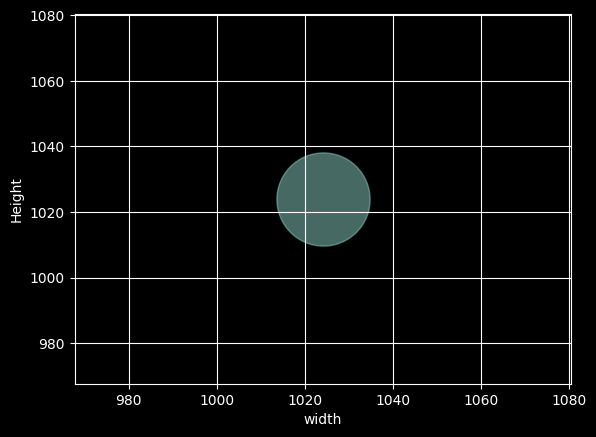

In [12]:
Dict = {}
for images in [train_images , test_images , val_images]:
    for image in images:
        im_shape = image.shape[:2]
        if(im_shape not in Dict.keys()):
            Dict[im_shape]=0
        Dict[im_shape] +=1

arr = np.array(list (Dict.keys())) 
num = np.array(list(Dict.values()))

plt.scatter(arr[:,1],arr[:,0] , s=num *100 ,alpha=0.5)
plt.ylabel('Height')
plt.xlabel('width')
plt.grid()
plt.show()

In [13]:
Dict 

{(1024, 1024): 45}

In [14]:
factor = 32
im_h =  1024
im_w = 1024

desired_shape = ( int(( im_h//factor )* factor) , int((im_w//factor) *factor) )
# desired_shape = (512,512)
config['dataset']['_image_shape'] = desired_shape

def  resize_images_to_numpy(Data ):
    List = []
    for image in tqdm(Data):
        # print(image.dtype)
        new_image = np.array(Image.fromarray(image).resize((desired_shape[1],desired_shape[0])))
        List.append(new_image)
        
    return np.array(List , dtype = np.float32)
    
def  resize_masks_to_numpy(Data):
    List = []
    for mask in tqdm(Data): ## implies RGB
        new_mask = Image.fromarray(mask).resize((desired_shape[1],desired_shape[0]))
        if( np.array(new_mask).ndim == 3):
            new_mask = np.arranp.sum(new_mask , axis=-1,keepdims=True)
        else: ## Implies  Graysclae
            new_mask = np.expand_dims(new_mask, axis = -1)
        
        new_mask = np.where(new_mask > 0 ,1 ,0)
    
        List.append(new_mask)
    return np.array(List , dtype = np.float32)

train_images = resize_images_to_numpy(train_images )
train_masks  = resize_masks_to_numpy(train_masks )

test_images = resize_images_to_numpy(test_images )
test_masks  = resize_masks_to_numpy(test_masks )

val_images = resize_images_to_numpy(val_images )
val_masks  = resize_masks_to_numpy(val_masks )

100%|██████████| 5/5 [00:00<00:00, 358.86it/s]


## > Preprocessing (only form images) & Datasplit

In [15]:
def image_01float_to_unit8(image_float):
    return (image_float*255).astype(np.uint8)
    
def image_clahe_gray(image , clipLimit  = 10 , tileGridLen = 10):
    clahe = cv2.createCLAHE(clipLimit=clipLimit , tileGridSize= (tileGridLen,tileGridLen) )
    # print(np.shape(image))
    # print(np.max(image) , np.array(image).dtype)
    clahe_image = clahe.apply(image)
    
    return clahe_image
# //---------------------------------------------------------------------------------------------------------------
def morphological_operations(image, kernel_size = 15,channel = 1):
    # Convert RGB image to grayscale
    # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    if( np.ndim(image)==3):
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
        # grayscale_image_cl = image_clahe_gray(grayscale_image,4,16)
    # Apply morphological operations (Top-hat filtering)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    tophat_result = cv2.morphologyEx(grayscale_image, cv2.MORPH_TOPHAT, kernel)
    return tophat_result
    
# Apply gamma correction-----------------------------------------------------------------------------------
def image_gamma_corr( image , gamma = 1.5): ## Uint8 .
    std_image = image_standarize(image)
    
    corrected_image = np.power(std_image , 1/gamma)
    # Convert back to uint8 format
    corrected_image_uint8 = (corrected_image * 255).astype(np.uint8)
    return corrected_image_uint8
# ///-----------------------------------------------------------------------------------------------------------------
from skimage.filters import frangi

def frangi_vessel_enhancement(image , alpha = 0.5 ,beta=0.5, gamma=1 ,kernel_size = 5,channel = 1):
    # Convert RGB image to grayscale
    if(np.ndim(image) == 3):
        # grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        grayscale_image = image[...,channel]
    else :
        grayscale_image = image
    # Apply Frangi filter
    frangi_result = frangi(grayscale_image ,alpha = alpha ,beta=beta ,gamma = gamma ,) 
    frangi_result =  image_01float_to_unit8(frangi_result)
    # frangi_result = frangi(grayscale_image.
    blurred = cv2.GaussianBlur(frangi_result  , (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    return blurred 
# ///-----------------------------------------------------------------------------------------------------------------
def image_normalise(image):  # for any type of images 
    mean = np.mean(image, axis=(0, 1))
    std_dev = np.std(image, axis=(0, 1))
# Normalize image
    normalised_image = (image - mean) / std_dev
    return normalised_image
    
def clip_image(image , clip_range =[0,2]): # for any type of images
    normalised_image = image_normalise(image)
    clip_image = np.clip( normalised_image, *clip_range)
    clip_std_image = (clip_image - clip_range[0] )/ (clip_range[1]-clip_range[0])
    clip_image = image_01float_to_unit8(clip_std_image)
    return clip_image

# //--------------------------------------------------------------------------------------------------
def  image_standarize(image_float): ## for all type of image
    # Calculate mean and standard deviation for each channel
    min_ = np.min(image_float, axis=(0, 1))
    max_ = np.max(image_float, axis=(0, 1))
    # Normalize image
    standarized_image = (image_float - min_) / (max_ - min_)
    return standarized_image 

In [16]:
num = 4
func_Dict ={
    'clahe' :image_clahe_gray,
    'gamma_correction':image_gamma_corr,
    'morphological_operations':morphological_operations,
#     'frangi_vessel_enhancement' : frangi_vessel_enhancement,
    'norm_clip': clip_image,
}

In [17]:
param_Dict = {'clahe': {'clipLimit': np.array([ 4,  8, 12, 16]),
           'tileGridLen': np.array([17, 27, 28, 31])},
 'gamma_correction': {'gamma': np.array([0.5, 0.6, 0.7, 0.8])},
 'morphological_operations': {'kernel_size': np.array([100, 133, 166, 200])},
 'norm_clip': {'clip_range': np.array([[ 0.  ,  2.  ],
       [ 0.  ,  2.5 ],
       [ 0.  ,  3.  ],
       [ 0.25,  2.25],
       [-0.25,  2.  ]])}}
# param_Dict = {
#     'clahe' : {
#         'clipLimit' : np.linspace(4,16,num).astype('int'),
#         'tileGridLen' : np.random.randint(16,32,(num,),)
#    },
    
#      'gamma_correction':{
#         'gamma' :np.linspace(0.5,0.8,num),
#     },
    
#      'morphological_operations':{
#         'kernel_size' :np.linspace(100,200,num).astype('int'),
#     },
# #      'frangi_vessel_enhancement':{
# #         'kernel_size': 2* np.random.randint(0,2,(num,))+1,
# #         'gamma':np.random.uniform(0.5,2.5,(num,))
# #     },
#     'norm_clip':{
#         'clip_range':np.array([[0,2],[0,2.5] ,[0,3],[0.25,2.25],[-0.25,2]])
#     },
# }
# pprint(param_Dict)

In [18]:
theta = 50
def concat_aug(image):
    image_List = []
    
    image = np.array(image,dtype=np.uint8)
    image_List.append(image[...,0])
    image_List.append(image[...,1])
    image_List.append(image[...,2])
    image_green = image[...,1]
    
    image_roi = np.where(np.max(image,axis =-1) > theta ,1,0)
#     display_image(image_roi)
    
    for op_name , func in func_Dict.items():
        
        for j in range(num):
            Dict = {}
            for param , vals in param_Dict[op_name].items():
                Dict[param] = vals[j]
                
        ##  will focus on green pixel only 
            img = func(image_green,**Dict)
            # print( op_name , np.max(img),np.shape(img))
            image_List.append(img*image_roi)
            
    image_array = np.moveaxis(image_List ,0, -1)
    return image_array
    
def Augment_train(X):
    X_new = []
    for image in tqdm(X):
        new_image_set = concat_aug(image)        
        X_new.append(new_image_set)
    return np.array(X_new , dtype = 'uint8')

In [19]:
%time train_images = Augment_train(train_images)
%time test_images = Augment_train(test_images)
%time val_images = Augment_train(val_images)

100%|██████████| 31/31 [01:47<00:00,  3.46s/it]


CPU times: user 1min 47s, sys: 2.88 s, total: 1min 50s
Wall time: 1min 48s


100%|██████████| 9/9 [00:30<00:00,  3.42s/it]


CPU times: user 30.9 s, sys: 844 ms, total: 31.8 s
Wall time: 31.3 s


100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


CPU times: user 17.2 s, sys: 486 ms, total: 17.7 s
Wall time: 17.4 s


In [24]:
 train_images.shape ,test_images.shape , val_images.shape

((31, 1024, 1024, 19), (9, 1024, 1024, 19), (5, 1024, 1024, 19))

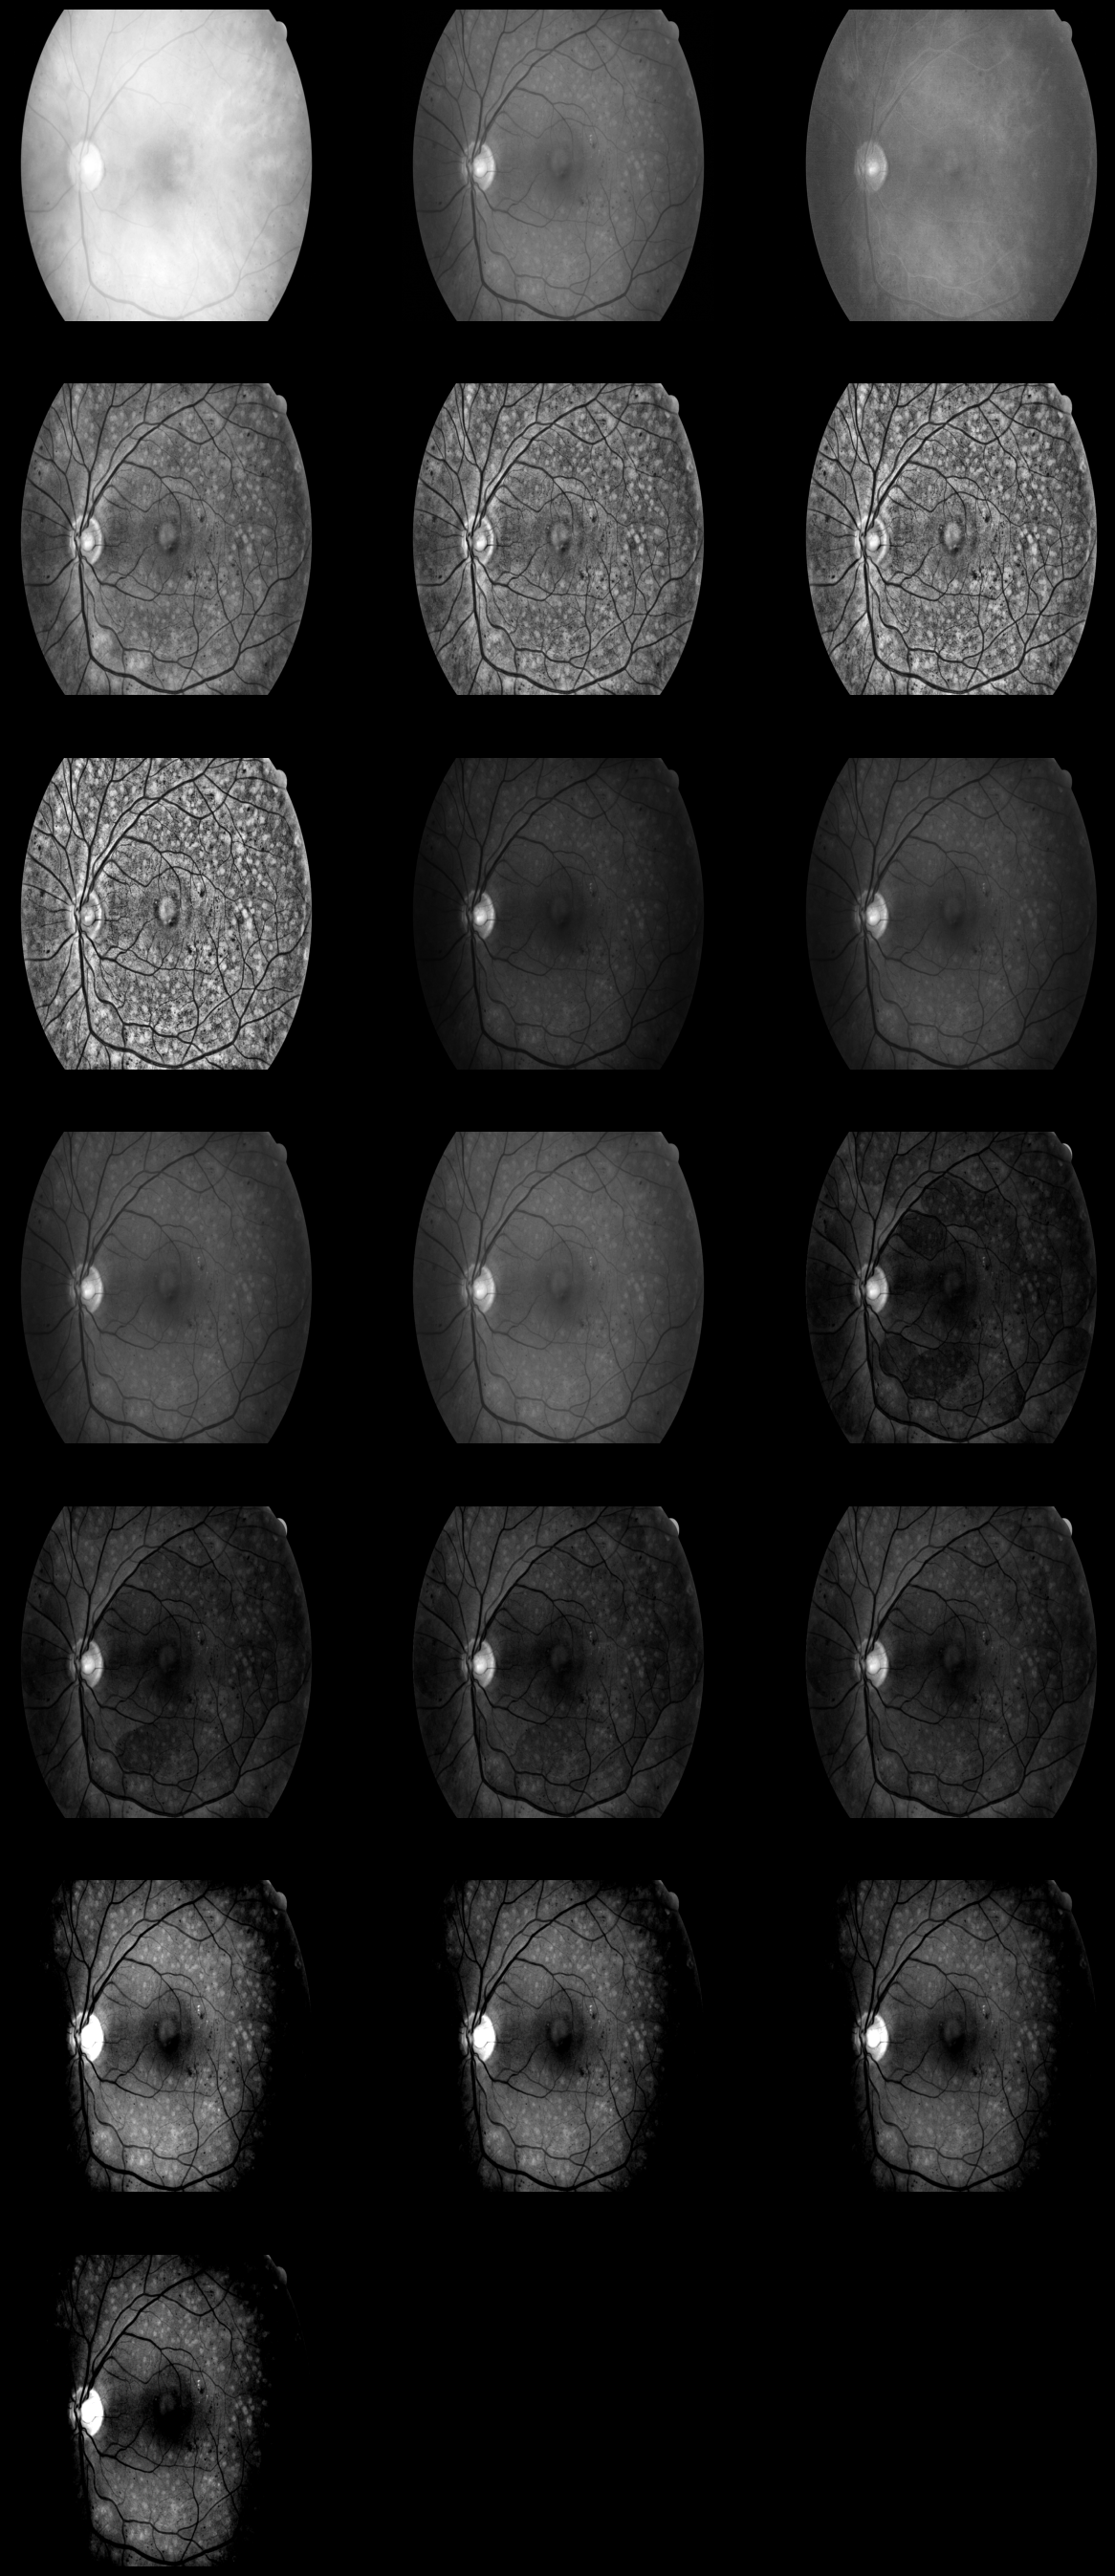

In [20]:
List = []
index = 0
num = 19
for i in range(num):
    List.append(val_images[index][...,i])

display_images(List,cmap = 'gray',size = 5,grid=(10,3))

## > Model Building & importing

### > get the base Models

In [21]:
# !pip install segmentation_models

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [22]:
# !pip install keras_unet_collection

In [23]:
# from keras_unet_collection import models as unet_models
# from keras_unet_collection import losses as unet_losses

In [24]:
config['dataset']['_image_shape'] = desired_shape

In [25]:
# num = 0
# model_name = Model_names[0]
# # backbone_name ='EfficientNetB0'
# # backbone_name ='efficientnetb0'

# image_shape =  config['dataset']['_image_shape'] 

In [26]:
import sys

sys.path.append(base_path + "my-unet-collection/MyKerasLiberary") 

import unet_models as unet_models

In [27]:
num = 2
model_name = Model_names[num]
image_shape =  config['dataset']['_image_shape'] 
n_channel = train_images[0].shape[-1]


unet_models.General_Config['image_shape']= image_shape
unet_models.General_Config['n_channel']= n_channel
unet_models.Model_Config['n_level'] = 4
unet_models.Model_Config['n_unit'] = 32
unet_models.Model_Config['dilation'] = 1
Model = unet_models.BuildUnet(num = num)

In [28]:
# model_name = Model_names[4]
# image_shape =  config['dataset']['_image_shape'] 
# n_channel = train_images[0].shape[-1]


# unet_models.General_Config['image_shape']= image_shape
# unet_models.General_Config['n_channel']= n_channel
# unet_models.Model_Config['n_level'] = 4
# unet_models.Model_Config['n_unit'] = 32
# unet_models.Model_Config['dilation'] = 1

# Model = unet_models.BuildUnet(num = 0 , has_attention=True)

In [29]:
models.clone_model(Model)

<Functional name=Unet_Model, built=True>

In [30]:
Model.summary()

Model: "Unet_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 19)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1024,      │        640 │ input_layer[0][0] │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1024,      │      9,248 │ conv2d[0][0]      │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024,      │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1024,      │          0 │ conv2d[0][0],     │
│                     │ 1024, 32)         │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1024,      │      9,248 │ add[0][0]         │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1024,      │          0 │ conv2d[0][0],     │
│                     │ 1024, 32)         │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1024,      │      9,248 │ add_1[0][0]       │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1024,      │      9,248 │ activation_2[0][… │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1024,      │          0 │ batch_normalizat… │
│ (Activation)        │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1024,      │          0 │ activation_2[0][

 Total params: 24,037,825 (91.70 MB)

 Trainable params: 24,020,161 (91.63 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [31]:
# def get_segmentation_model_0():
#     n_class = 1
#     BaseModel = sm.Unet(backbone_name = backbone_name , 
#                                     input_shape = image_shape+(3,),
#                                     encoder_weights='imagenet',
#                                      classes=1,
#                                     activation = 'sigmoid',
#                                     encoder_freeze = True,
#                                     decoder_block_type ='upsampling',
#                                    )
#     return BaseModel
# def get_segmentation_model_1():
#     Model = unet_models.unet_2d(image_shape+(3,) ,
#                             n_labels = 1,
#                             filter_num=[32,64,128,256,512],
#                             output_activation='Sigmoid',
#                             weights='imagenet',
#                             # name = 'my_unet',
#                             batch_norm=True,
#                             backbone=backbone_name,
#                             freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_2():
#     Model = unet_models.r2_unet_2d(image_shape + (3,),
#                                n_labels = 1,
#                                 filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                 # name = 'my_unet',
#                                batch_norm=True,
#                                 # backbone='bacbackbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_3():
#     Model = unet_models.att_unet_2d(image_shape+(3,) ,
#                                n_labels = 1,
#                                filter_num=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                # weights='imagenet',
#                                # name = 'my_unet',
#                                batch_norm=True,
            
#                                 # backbone = backbone_name,
#                             # freeze_backbone=True,
#               )
#     return Model
# def get_segmentation_model_4():
#     Model = unet_models.unet_3plus_2d(
#                                 image_shape+(3,) ,
#                                 n_labels = 1,

#                                 filter_num_down=[32,64,128,256,512],
#                                 # filter_num_up=[32,64,128,256,512],
#                                output_activation='Sigmoid',
#                                backbone='EfficientNetB0',
#                                weights='imagenet',
#                                 batch_norm=True,
#                                 # name = 'my_unet',
#                                 freeze_backbone=True,
#                                 filter_num_skip = [64,]*4,
#               )
#     return Model

### > build Model 

In [32]:
# sm.get_preprocessing(backbone_name)(image)

In [33]:
# Model = get_segmentation_model_0()
# Model.summary(100)

In [34]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# x_rescale = layers.Rescaling(1/255.)(fn_input)

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'tanh')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)
# x_add = layers.BatchNormalization()(x_add)

# fn_output = layers.Conv2D(1,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'sigmoid')(x6)

# # fn_output  = Model(x1)
# pre_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# pre_Model.summary(100)
# models.clone_model(pre_Model)

In [35]:
# n_unit = 8
# dilation = 2 
# n_channel = 18 
# fn_input = layers.Input(shape = image_shape + (n_channel ,))

# x1 = layers.Conv2D(n_unit, kernel_size  = 1 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x3  = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input)
# x_add = layers.Add()([x1,x2,x3]) 
# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_add)

# x_out = un_model_1(fn_input)
# x_conc =  layers.Concatenate()([x_out*255 , x_add])

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(x_conc)
# x6 = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same',dilation_rate = dilation ,kernel_initializer= 'ones',activation = 'relu')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs = x6,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [36]:
# n_unit = 8
# dilation = 2 
# n_channel = 13 
# fn_input = layers.Input(shape = image_shape + (n_channel,))
# # x_rescale = layers.Rescaling(1/255.)(fn_input)
# x_rescale = fn_input

# x1 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'tanh')(x_rescale)
# x2 = layers.Conv2D(n_unit,kernel_size  = 2 ,strides=1,dilation_rate = dilation, padding= 'same',activation = 'tanh')(x_rescale)
# x3 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,dilation_rate = dilation ,padding= 'same',activation = 'tanh')(x_rescale)
# # x3  = layers.Conv2D(1,kernel_size  = 5 ,strides=1,padding= 'same',kernel_initializer= 'ones',activation = 'relu')(fn_input
# x_add = layers.Add()([x1,x2,x3]) 
# # x_add = layers.BatchNormalization()(x_add)

# x4 = layers.Conv2D(n_unit,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# x5 = layers.Conv2D(n_unit,kernel_size  = 1 ,strides=1,padding= 'same',activation = 'relu')(x_rescale)

# x_add = layers.Add()([x4,x5]) 
# # x_add = layers.BatchNormalization()(x_add)

# x6 = layers.Conv2D(4,kernel_size  = 3 ,strides=1,padding= 'same',activation = 'relu')(x_add)
# # x6 = layers.BatchNormalization()(x6)

# fn_output = layers.Conv2D(3,kernel_size  = 3 ,strides=1,padding= 'same')(x6)

# # fn_output  = Model(x1)
# prev_Model = models.Model(inputs = fn_input , outputs =fn_output,name = 'model_base')

# prev_Model.summary(100)
# models.clone_model(prev_Model)

In [37]:
# un_model_1 = pre_Model
# un_model_1.set_weights(Unet_Model.get_weights())

In [38]:
# un_model_2 = pre_Model
# un_model_2.set_weights(un_model_1.get_weights())

In [39]:
# Unet_Model = models.Sequential([prev_Model,Model])
# Unet_Model.summary()
# models.clone_model(Unet_Model)

In [40]:
# Unet_Model = pre_Model
# Unet_Model = Model

In [41]:
# Unet_Model(np.zeros(shape = (1,)+image_shape+ (28,))).shape

## > Model Training 

In [42]:
model_weights_path1 = 'unet_model_best1.weights.h5'
model_weights_path2 = 'unet_model_best2.weights.h5'
model_weights_path3 = 'unet_model_best3.weights.h5'
model_weights_path4 = 'unet_model_best4.weights.h5'
model_weights_path5 = 'unet_model_best5.weights.h5'
model_weights_path6 = 'unet_model_best6.weights.h5'


checkpoint_callback = callbacks.ModelCheckpoint(  ## To save Best Models
    model_weights_path1,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True, ## will save best weights. 
    save_weights_only = True, ## If false will save whole model .. .
    mode = 'auto', # if monitor val_loss that it will be min else if val_accuracy that it will be Max..
    save_freq = 'epoch', ## we will do this after every epoch .
)

plateau_callback = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.6, ## reduce by this factor . ## lr = lr*0.1
    patience = 5, ## wait till these number of epochs ,
    verbose = 1,
    mode = 'auto', ## similar to what studied above,,i..e Min or Max..
    min_delta = 0.0, ## if change is less than delta than we will consider it as no improvement . 
    cooldown = 0,  ## to wait after we have updated our lr ,,
    min_lr = 0, ## dont go below this lr.
)

In [43]:
# os.removedirs(base_path + 'liberary')

In [44]:
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss()
# bce_loss = sm.losses.BinaryCELoss()
# jaccard_loss = sm.losses.JaccardLoss()
# hybrid_loss1 = dice_loss + 1.*(focal_loss)
# hybrid_loss2 = dice_loss + 1.*(bce_loss) + 1.*jaccard_loss
# hybrid_loss3 = jaccard_loss + bce_loss
# # loss = dice_loss
# # loss = hybrid_loss1
# # loss = bce_loss
# # loss = focal_loss
loss = sm.losses.JaccardLoss()
# # loss = sm.losses.binary_focal_jaccard_loss
# # loss = hybrid_loss3

In [45]:
def specificity(y_true, y_pred):
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float32'))
    total_background = tf.keras.backend.sum(1 - y_true)
    return tn / (total_background + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float32'))
    total_foreground = tf.keras.backend.sum(y_true)
    return tp / (total_foreground + tf.keras.backend.epsilon())

# Assuming y_true and y_pred are segmentation masks with values in {0, 1} for background and foreground, respectively
# Compute specificity and sensitivity
# spec = specificity(y_true, y_pred)
# sens = sensitivity(y_true, y_pred)

In [46]:
metrics_ = [
            # metrics.MeanIoU(num_classes=2 , name = 'mean_iou_score') ,
            sm.metrics.IOUScore(name = 'iou_score',),
            'accuracy', 
            sm.metrics.FScore(name = 'f1score'),
            metrics.AUC(name = 'auc',),
            # metrics.BinaryIoU(name='binary_iou'),
            specificity,
            sensitivity
           ]

lr = 0.005
Model.compile(
    optimizer = optimizers.Adam(learning_rate=lr),
    loss = loss,
    metrics = metrics_,
)

In [47]:
History = {}
def add_to_history(history):
    for metric,values  in history.history.items():
        if(metric not in History.keys()):
            History[metric] = []
        History[metric] += values

### Augmentatiion

In [48]:
transform = A.Compose(
    [
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
    ]
)

def Augment_it(X_train ,Y_train,rescale = False):
    Image_List = []
    Mask_List = []
    for image , mask  in zip(X_train,Y_train):
        Dict = { 'image':image,
                        'mask':mask ,}
        trans_data = transform(**Dict)
        
        Image_List.append(trans_data['image'])
        Mask_List.append(trans_data['mask'])
    
    Image_List = np.array(Image_List)         
    Mask_List = np.array(Mask_List)         
    
    if(rescale):
        Image_List/=255.
    return Image_List,Mask_List

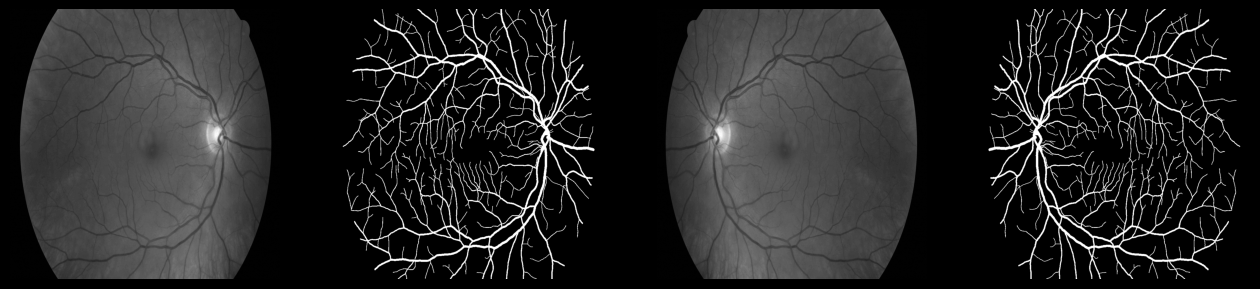

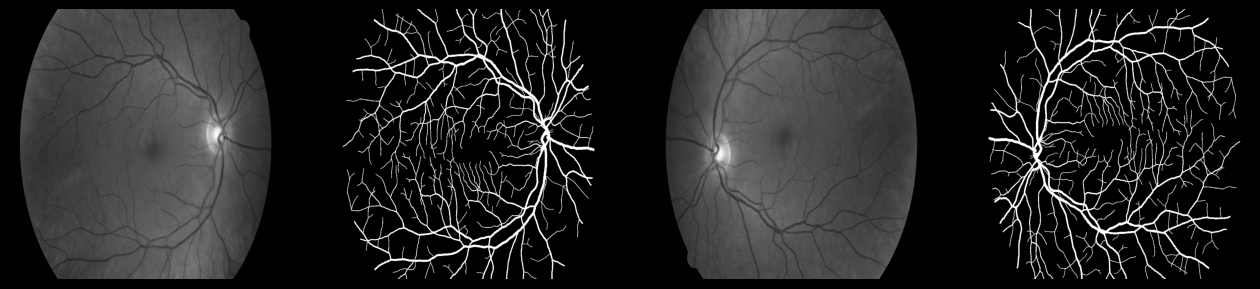

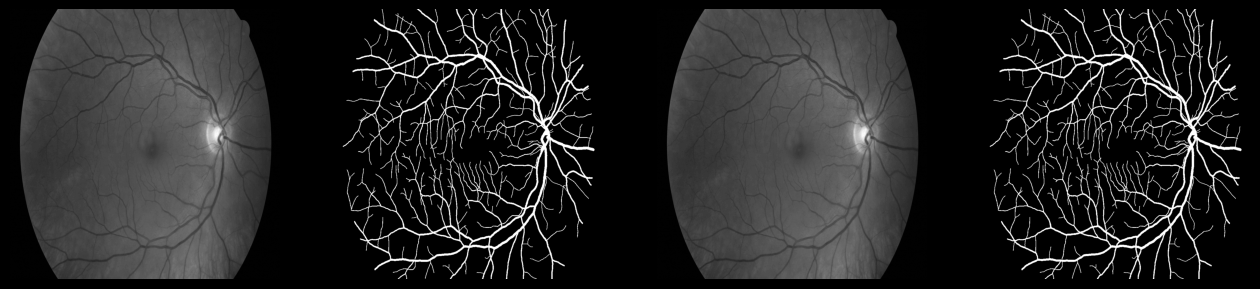

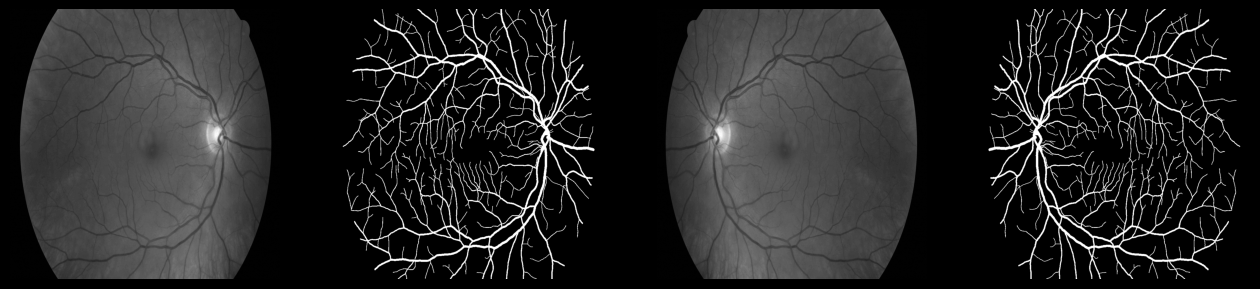

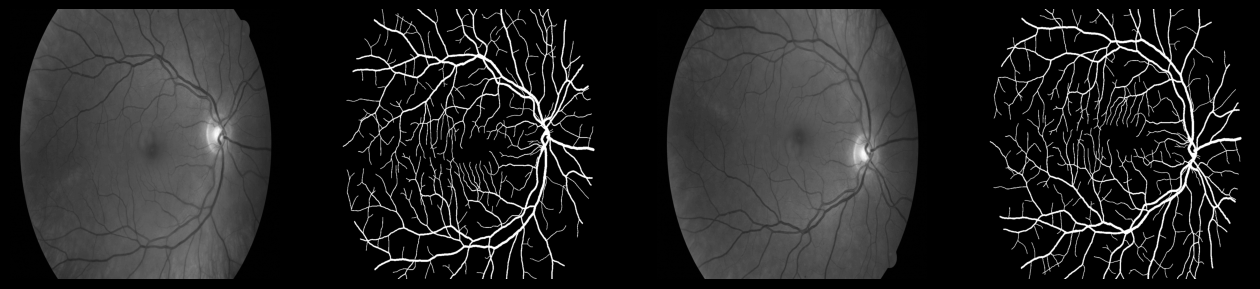

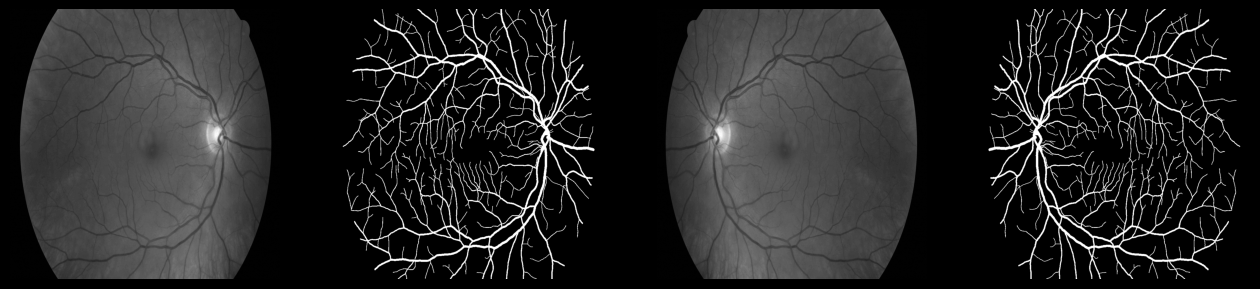

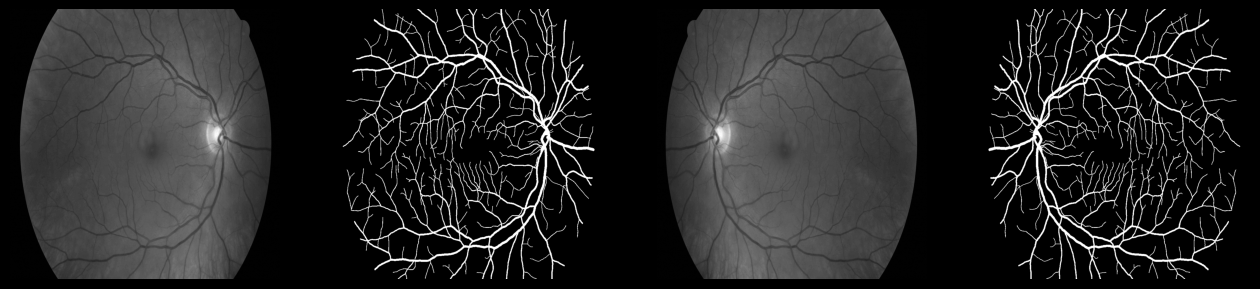

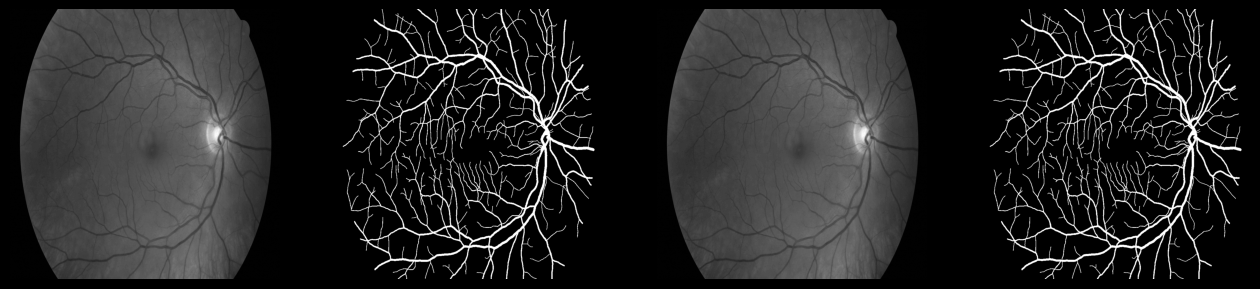

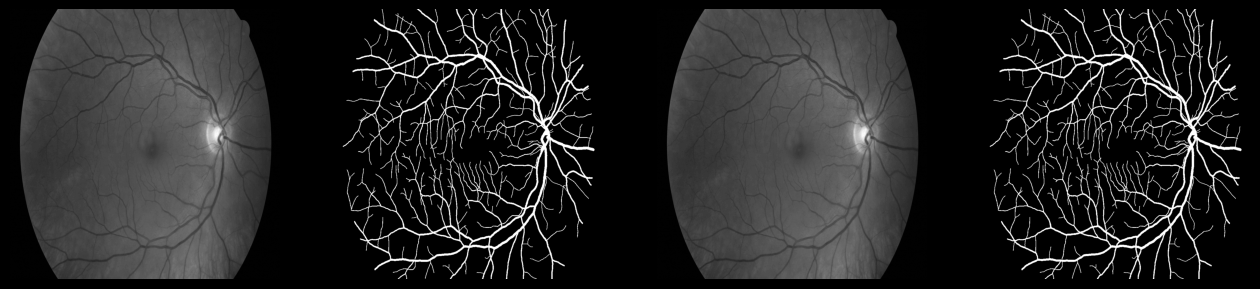

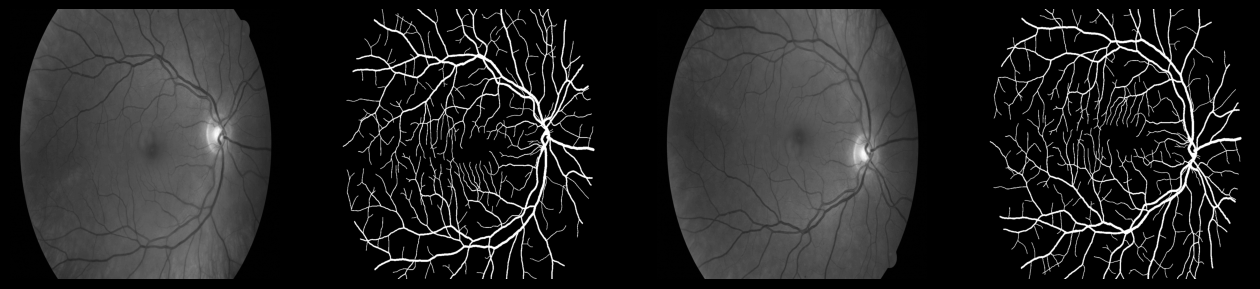

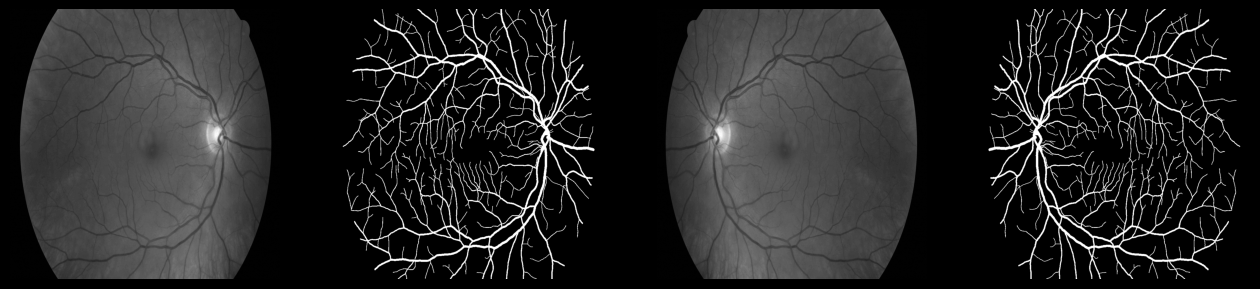

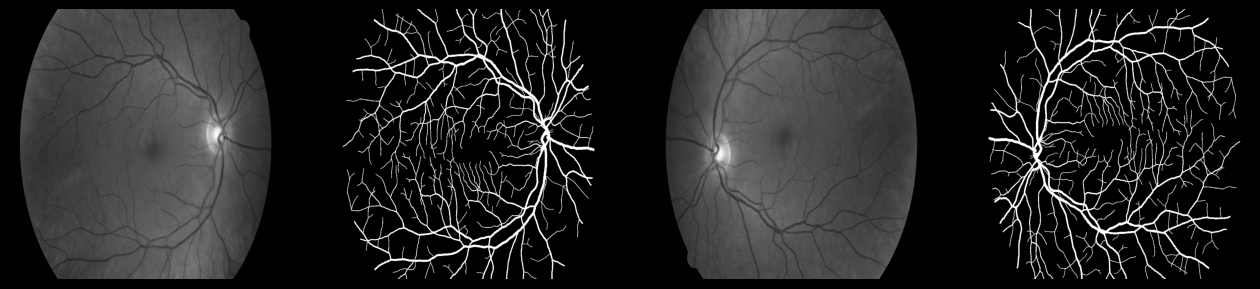

In [49]:
num_ = 12
index = 1
for i in range(num_):
    X_train,Y_train =Augment_it(train_images[:1],train_masks[:1])
    display_images([train_images[0][...,index],train_masks[0] ,X_train[0][...,index],Y_train[0]] ,size = 4,cmap = 'gray')

### Training

In [50]:
batch_size = 2

# back_bone_name =  'efficientnetb0' 
# preprocess = sm.get_preprocessing(back_bone_name)

indexes = np.arange(train_images.shape[0])
patience = 5
temp_wait = 0
factor = 0.5
lr_scale = 1.2
monitor = 'val_loss'
best_monitor_value = 1234647  

In [51]:
n_epoch = 150

for epoch in tqdm(range(n_epoch)):
    indexes = np.random.permutation(indexes)

    X_train ,Y_train = train_images[indexes] , train_masks[indexes] 
    X_train ,Y_train = Augment_it(X_train ,Y_train )
    
    ## preprocessing .......................................................................................................
    # X_train = preprocess(X_train)
    # X_val = preprocess(val_images)
    
    ## Plateau Callback .....................................................................................................
    if(monitor in History.keys()) :
        # print(temp_wait ,History[monitor][-1] , best_monitor_value)
        if (History[monitor][-1] < best_monitor_value):
            best_monitor_value = History[monitor] [-1]
            temp_wait = patience
        else:
            if(temp_wait > 0):
                temp_wait -= 1
            else:
                prev_lr =np.array(Model.optimizer.learning_rate)
                new_lr = (prev_lr) * factor
                setattr(Model.optimizer, 'learning_rate',new_lr)
                print(f">>>>>>>> | Changing Learning Rate from {prev_lr} to {new_lr}")
                
                patience = int(patience * lr_scale)
                temp_wait = patience
    print('>>>>>>>> | Learning is :', np.array(Model.optimizer.learning_rate),"| Patience is",patience ,'| temp_wait is',temp_wait)
    # ///----------------------------------------------------------------------------------------
    history = Model.fit(
                X_train,
                Y_train,
                
                validation_data=[val_images ,val_masks],
                epochs  = 1,
                batch_size = batch_size,
                callbacks=([checkpoint_callback , 
#                             plateau_callback,
                           ]
                        ),
                shuffle = False,
        
                )
    add_to_history(history)

  0%|          | 0/150 [00:00<?, ?it/s]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0


2024-05-12 19:07:00.819760: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,32,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 19:07:01.019741: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.200078999s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,32,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 19:07:03.063510: E exter

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6341 - auc: 0.7886 - f1score: 0.3346 - iou_score: 0.2076 - loss: 0.7926 - sensitivity: 0.7581 - specificity: 0.5768
Epoch 1: val_loss improved from inf to 0.90394, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 212s 6s/step - accuracy: 0.6427 - auc: 0.7936 - f1score: 0.3411 - iou_score: 0.2128 - loss: 0.7876 - sensitivity: 0.7604 - specificity: 0.5852 - val_accuracy: 0.0969 - val_auc: 0.5005 - val_f1score: 0.1751 - val_iou_score: 0.0961 - val_loss: 0.9039 - val_sensitivity: 1.0000 - val_specificity: 0.0011


  1%|          | 1/150 [03:35<8:54:11, 215.11s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9325 - auc: 0.9018 - f1score: 0.6944 - iou_score: 0.5325 - loss: 0.4678 - sensitivity: 0.7230 - specificity: 0.9533
Epoch 1: val_loss did not improve from 0.90394
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9326 - auc: 0.9015 - f1score: 0.6954 - iou_score: 0.5338 - loss: 0.4668 - sensitivity: 0.7230 - specificity: 0.9537 - val_accuracy: 0.0960 - val_auc: 0.5000 - val_f1score: 0.1750 - val_iou_score: 0.0960 - val_loss: 0.9040 - val_sensitivity: 1.0000 - val_specificity: 5.2753e-06


  1%|▏         | 2/150 [04:10<4:29:19, 109.18s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9404 - auc: 0.8899 - f1score: 0.7348 - iou_score: 0.5822 - loss: 0.4177 - sensitivity: 0.7348 - specificity: 0.9659
Epoch 1: val_loss improved from 0.90394 to 0.90394, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9406 - auc: 0.8903 - f1score: 0.7356 - iou_score: 0.5832 - loss: 0.4165 - sensitivity: 0.7356 - specificity: 0.9661 - val_accuracy: 0.0969 - val_auc: 0.5005 - val_f1score: 0.1751 - val_iou_score: 0.0961 - val_loss: 0.9039 - val_sensitivity: 1.0000 - val_specificity: 0.0011


  2%|▏         | 3/150 [04:45<3:04:32, 75.32s/it] 

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9488 - auc: 0.9014 - f1score: 0.7746 - iou_score: 0.6328 - loss: 0.3673 - sensitivity: 0.7674 - specificity: 0.9723
Epoch 1: val_loss improved from 0.90394 to 0.90329, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9487 - auc: 0.9014 - f1score: 0.7742 - iou_score: 0.6322 - loss: 0.3678 - sensitivity: 0.7675 - specificity: 0.9722 - val_accuracy: 0.1045 - val_auc: 0.5043 - val_f1score: 0.1762 - val_iou_score: 0.0967 - val_loss: 0.9033 - val_sensitivity: 0.9990 - val_specificity: 0.0095


  3%|▎         | 4/150 [05:20<2:24:28, 59.37s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9512 - auc: 0.8957 - f1score: 0.7773 - iou_score: 0.6377 - loss: 0.3625 - sensitivity: 0.7539 - specificity: 0.9763
Epoch 1: val_loss did not improve from 0.90329
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9511 - auc: 0.8958 - f1score: 0.7773 - iou_score: 0.6376 - loss: 0.3627 - sensitivity: 0.7545 - specificity: 0.9761 - val_accuracy: 0.0969 - val_auc: 0.5005 - val_f1score: 0.1751 - val_iou_score: 0.0961 - val_loss: 0.9039 - val_sensitivity: 1.0000 - val_specificity: 0.0011


  3%|▎         | 5/150 [05:54<2:01:30, 50.28s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9521 - auc: 0.9101 - f1score: 0.7925 - iou_score: 0.6573 - loss: 0.3427 - sensitivity: 0.7967 - specificity: 0.9720
Epoch 1: val_loss did not improve from 0.90329
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9521 - auc: 0.9098 - f1score: 0.7921 - iou_score: 0.6569 - loss: 0.3432 - sensitivity: 0.7959 - specificity: 0.9721 - val_accuracy: 0.0970 - val_auc: 0.5005 - val_f1score: 0.1751 - val_iou_score: 0.0961 - val_loss: 0.9039 - val_sensitivity: 1.0000 - val_specificity: 0.0011


  4%|▍         | 6/150 [06:27<1:47:07, 44.64s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9539 - auc: 0.9085 - f1score: 0.7940 - iou_score: 0.6597 - loss: 0.3403 - sensitivity: 0.7925 - specificity: 0.9744
Epoch 1: val_loss did not improve from 0.90329
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9538 - auc: 0.9084 - f1score: 0.7938 - iou_score: 0.6594 - loss: 0.3406 - sensitivity: 0.7924 - specificity: 0.9743 - val_accuracy: 0.0980 - val_auc: 0.5011 - val_f1score: 0.1753 - val_iou_score: 0.0962 - val_loss: 0.9038 - val_sensitivity: 0.9999 - val_specificity: 0.0021


  5%|▍         | 7/150 [07:02<1:38:15, 41.23s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9544 - auc: 0.9075 - f1score: 0.7956 - iou_score: 0.6610 - loss: 0.3388 - sensitivity: 0.7853 - specificity: 0.9759
Epoch 1: val_loss did not improve from 0.90329
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9544 - auc: 0.9076 - f1score: 0.7957 - iou_score: 0.6610 - loss: 0.3385 - sensitivity: 0.7856 - specificity: 0.9758 - val_accuracy: 0.0987 - val_auc: 0.5013 - val_f1score: 0.1752 - val_iou_score: 0.0961 - val_loss: 0.9039 - val_sensitivity: 0.9995 - val_specificity: 0.0025


  5%|▌         | 8/150 [07:36<1:32:17, 39.00s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9545 - auc: 0.9101 - f1score: 0.7970 - iou_score: 0.6646 - loss: 0.3354 - sensitivity: 0.7980 - specificity: 0.9750
Epoch 1: val_loss improved from 0.90329 to 0.90289, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9546 - auc: 0.9102 - f1score: 0.7972 - iou_score: 0.6649 - loss: 0.3351 - sensitivity: 0.7982 - specificity: 0.9750 - val_accuracy: 0.1078 - val_auc: 0.5089 - val_f1score: 0.1768 - val_iou_score: 0.0971 - val_loss: 0.9029 - val_sensitivity: 1.0000 - val_specificity: 0.0127


  6%|▌         | 9/150 [08:11<1:28:45, 37.77s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9569 - auc: 0.9102 - f1score: 0.8087 - iou_score: 0.6794 - loss: 0.3208 - sensitivity: 0.7977 - specificity: 0.9775
Epoch 1: val_loss improved from 0.90289 to 0.79423, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9570 - auc: 0.9104 - f1score: 0.8091 - iou_score: 0.6799 - loss: 0.3204 - sensitivity: 0.7980 - specificity: 0.9776 - val_accuracy: 0.6662 - val_auc: 0.7825 - val_f1score: 0.3227 - val_iou_score: 0.1942 - val_loss: 0.7942 - val_sensitivity: 0.9317 - val_specificity: 0.5639


  7%|▋         | 10/150 [08:46<1:26:25, 37.04s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9545 - auc: 0.9175 - f1score: 0.7996 - iou_score: 0.6677 - loss: 0.3321 - sensitivity: 0.8236 - specificity: 0.9710
Epoch 1: val_loss did not improve from 0.79423
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9545 - auc: 0.9172 - f1score: 0.7995 - iou_score: 0.6676 - loss: 0.3320 - sensitivity: 0.8227 - specificity: 0.9711 - val_accuracy: 0.1043 - val_auc: 0.5042 - val_f1score: 0.1758 - val_iou_score: 0.0964 - val_loss: 0.9035 - val_sensitivity: 0.9984 - val_specificity: 0.0077


  7%|▋         | 11/150 [09:20<1:23:41, 36.13s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9540 - auc: 0.9024 - f1score: 0.7960 - iou_score: 0.6618 - loss: 0.3382 - sensitivity: 0.7852 - specificity: 0.9757
Epoch 1: val_loss did not improve from 0.79423
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9541 - auc: 0.9028 - f1score: 0.7965 - iou_score: 0.6625 - loss: 0.3375 - sensitivity: 0.7861 - specificity: 0.9758 - val_accuracy: 0.1323 - val_auc: 0.5219 - val_f1score: 0.1802 - val_iou_score: 0.0991 - val_loss: 0.9006 - val_sensitivity: 0.9990 - val_specificity: 0.0369


  8%|▊         | 12/150 [09:55<1:21:41, 35.52s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9584 - auc: 0.9138 - f1score: 0.8082 - iou_score: 0.6789 - loss: 0.3211 - sensitivity: 0.8095 - specificity: 0.9766
Epoch 1: val_loss did not improve from 0.79423
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9585 - auc: 0.9139 - f1score: 0.8086 - iou_score: 0.6794 - loss: 0.3205 - sensitivity: 0.8096 - specificity: 0.9766 - val_accuracy: 0.1664 - val_auc: 0.5429 - val_f1score: 0.1849 - val_iou_score: 0.1020 - val_loss: 0.8972 - val_sensitivity: 0.9971 - val_specificity: 0.0689


  9%|▊         | 13/150 [10:29<1:20:15, 35.15s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9594 - auc: 0.9252 - f1score: 0.8264 - iou_score: 0.7052 - loss: 0.2948 - sensitivity: 0.8324 - specificity: 0.9760
Epoch 1: val_loss improved from 0.79423 to 0.68407, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9593 - auc: 0.9250 - f1score: 0.8259 - iou_score: 0.7045 - loss: 0.2955 - sensitivity: 0.8320 - specificity: 0.9760 - val_accuracy: 0.8213 - val_auc: 0.8850 - val_f1score: 0.4653 - val_iou_score: 0.3046 - val_loss: 0.6841 - val_sensitivity: 0.9440 - val_specificity: 0.7701


  9%|▉         | 14/150 [11:04<1:19:40, 35.15s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9621 - auc: 0.9157 - f1score: 0.8254 - iou_score: 0.7035 - loss: 0.2965 - sensitivity: 0.8079 - specificity: 0.9815
Epoch 1: val_loss did not improve from 0.68407
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9620 - auc: 0.9158 - f1score: 0.8253 - iou_score: 0.7034 - loss: 0.2967 - sensitivity: 0.8085 - specificity: 0.9813 - val_accuracy: 0.6995 - val_auc: 0.8319 - val_f1score: 0.3776 - val_iou_score: 0.2328 - val_loss: 0.7655 - val_sensitivity: 0.9754 - val_specificity: 0.6611


 10%|█         | 15/150 [11:38<1:18:21, 34.82s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9604 - auc: 0.9243 - f1score: 0.8294 - iou_score: 0.7092 - loss: 0.2908 - sensitivity: 0.8290 - specificity: 0.9778
Epoch 1: val_loss did not improve from 0.68407
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9604 - auc: 0.9242 - f1score: 0.8291 - iou_score: 0.7087 - loss: 0.2912 - sensitivity: 0.8289 - specificity: 0.9778 - val_accuracy: 0.5311 - val_auc: 0.7364 - val_f1score: 0.2840 - val_iou_score: 0.1657 - val_loss: 0.8378 - val_sensitivity: 0.9602 - val_specificity: 0.4887


 11%|█         | 16/150 [12:12<1:17:18, 34.62s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9625 - auc: 0.9178 - f1score: 0.8287 - iou_score: 0.7081 - loss: 0.2919 - sensitivity: 0.8139 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.68407
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9624 - auc: 0.9181 - f1score: 0.8286 - iou_score: 0.7079 - loss: 0.2920 - sensitivity: 0.8148 - specificity: 0.9809 - val_accuracy: 0.5483 - val_auc: 0.7439 - val_f1score: 0.2859 - val_iou_score: 0.1670 - val_loss: 0.8297 - val_sensitivity: 0.9672 - val_specificity: 0.4884


 11%|█▏        | 17/150 [12:46<1:16:29, 34.51s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9631 - auc: 0.9239 - f1score: 0.8356 - iou_score: 0.7184 - loss: 0.2816 - sensitivity: 0.8274 - specificity: 0.9807
Epoch 1: val_loss improved from 0.68407 to 0.44341, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9630 - auc: 0.9238 - f1score: 0.8352 - iou_score: 0.7178 - loss: 0.2821 - sensitivity: 0.8276 - specificity: 0.9805 - val_accuracy: 0.9380 - val_auc: 0.9292 - val_f1score: 0.7039 - val_iou_score: 0.5452 - val_loss: 0.4434 - val_sensitivity: 0.9114 - val_specificity: 0.9278


 12%|█▏        | 18/150 [13:22<1:16:34, 34.81s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9625 - auc: 0.9204 - f1score: 0.8340 - iou_score: 0.7159 - loss: 0.2840 - sensitivity: 0.8246 - specificity: 0.9805
Epoch 1: val_loss improved from 0.44341 to 0.41309, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9624 - auc: 0.9203 - f1score: 0.8336 - iou_score: 0.7153 - loss: 0.2845 - sensitivity: 0.8248 - specificity: 0.9803 - val_accuracy: 0.9436 - val_auc: 0.9325 - val_f1score: 0.7258 - val_iou_score: 0.5722 - val_loss: 0.4131 - val_sensitivity: 0.9009 - val_specificity: 0.9375


 13%|█▎        | 19/150 [13:57<1:16:18, 34.95s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9619 - auc: 0.9245 - f1score: 0.8331 - iou_score: 0.7146 - loss: 0.2854 - sensitivity: 0.8373 - specificity: 0.9783
Epoch 1: val_loss did not improve from 0.41309
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9619 - auc: 0.9244 - f1score: 0.8329 - iou_score: 0.7142 - loss: 0.2857 - sensitivity: 0.8371 - specificity: 0.9783 - val_accuracy: 0.7984 - val_auc: 0.8574 - val_f1score: 0.4536 - val_iou_score: 0.2939 - val_loss: 0.7041 - val_sensitivity: 0.9146 - val_specificity: 0.7758


 13%|█▎        | 20/150 [14:32<1:15:18, 34.76s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9627 - auc: 0.9210 - f1score: 0.8358 - iou_score: 0.7184 - loss: 0.2815 - sensitivity: 0.8249 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.41309
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9626 - auc: 0.9211 - f1score: 0.8353 - iou_score: 0.7177 - loss: 0.2822 - sensitivity: 0.8253 - specificity: 0.9805 - val_accuracy: 0.9175 - val_auc: 0.9210 - val_f1score: 0.6330 - val_iou_score: 0.4635 - val_loss: 0.5328 - val_sensitivity: 0.9226 - val_specificity: 0.8949


 14%|█▍        | 21/150 [15:06<1:14:23, 34.60s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9616 - auc: 0.9187 - f1score: 0.8280 - iou_score: 0.7071 - loss: 0.2929 - sensitivity: 0.8211 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.41309
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9616 - auc: 0.9190 - f1score: 0.8280 - iou_score: 0.7071 - loss: 0.2927 - sensitivity: 0.8218 - specificity: 0.9795 - val_accuracy: 0.9346 - val_auc: 0.9000 - val_f1score: 0.5243 - val_iou_score: 0.3561 - val_loss: 0.6478 - val_sensitivity: 0.8708 - val_specificity: 0.8467


 15%|█▍        | 22/150 [15:40<1:13:36, 34.50s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9628 - auc: 0.9242 - f1score: 0.8345 - iou_score: 0.7172 - loss: 0.2829 - sensitivity: 0.8313 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.41309
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9628 - auc: 0.9241 - f1score: 0.8343 - iou_score: 0.7169 - loss: 0.2832 - sensitivity: 0.8311 - specificity: 0.9795 - val_accuracy: 0.9355 - val_auc: 0.8674 - val_f1score: 0.4497 - val_iou_score: 0.2922 - val_loss: 0.7048 - val_sensitivity: 0.8263 - val_specificity: 0.8029


 15%|█▌        | 23/150 [16:14<1:12:51, 34.42s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9625 - auc: 0.9260 - f1score: 0.8321 - iou_score: 0.7131 - loss: 0.2868 - sensitivity: 0.8406 - specificity: 0.9778
Epoch 1: val_loss did not improve from 0.41309
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9624 - auc: 0.9259 - f1score: 0.8319 - iou_score: 0.7128 - loss: 0.2871 - sensitivity: 0.8403 - specificity: 0.9778 - val_accuracy: 0.9430 - val_auc: 0.9096 - val_f1score: 0.7204 - val_iou_score: 0.5645 - val_loss: 0.4278 - val_sensitivity: 0.8733 - val_specificity: 0.9417


 16%|█▌        | 24/150 [16:48<1:11:58, 34.28s/it]

>>>>>>>> | Learning is : 0.005 | Patience is 5 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9598 - auc: 0.9180 - f1score: 0.8224 - iou_score: 0.7003 - loss: 0.2997 - sensitivity: 0.8248 - specificity: 0.9773
Epoch 1: val_loss did not improve from 0.41309
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9599 - auc: 0.9183 - f1score: 0.8227 - iou_score: 0.7008 - loss: 0.2993 - sensitivity: 0.8254 - specificity: 0.9773 - val_accuracy: 0.9136 - val_auc: 0.9095 - val_f1score: 0.6095 - val_iou_score: 0.4398 - val_loss: 0.5500 - val_sensitivity: 0.9089 - val_specificity: 0.8852


 17%|█▋        | 25/150 [17:23<1:11:29, 34.32s/it]

>>>>>>>> | Changing Learning Rate from 0.004999999888241291 to 0.0024999999441206455
>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9613 - auc: 0.9159 - f1score: 0.8227 - iou_score: 0.6991 - loss: 0.3009 - sensitivity: 0.8192 - specificity: 0.9789
Epoch 1: val_loss improved from 0.41309 to 0.37919, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9614 - auc: 0.9161 - f1score: 0.8233 - iou_score: 0.7000 - loss: 0.3000 - sensitivity: 0.8195 - specificity: 0.9790 - val_accuracy: 0.9528 - val_auc: 0.9181 - val_f1score: 0.7570 - val_iou_score: 0.6111 - val_loss: 0.3792 - val_sensitivity: 0.8683 - val_specificity: 0.9550


 17%|█▋        | 26/150 [17:58<1:11:39, 34.67s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9597 - auc: 0.9258 - f1score: 0.8220 - iou_score: 0.6986 - loss: 0.3014 - sensitivity: 0.8482 - specificity: 0.9735
Epoch 1: val_loss improved from 0.37919 to 0.34122, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9598 - auc: 0.9257 - f1score: 0.8227 - iou_score: 0.6996 - loss: 0.3005 - sensitivity: 0.8476 - specificity: 0.9738 - val_accuracy: 0.9584 - val_auc: 0.9321 - val_f1score: 0.7869 - val_iou_score: 0.6505 - val_loss: 0.3412 - val_sensitivity: 0.8721 - val_specificity: 0.9638


 18%|█▊        | 27/150 [18:33<1:11:24, 34.83s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9628 - auc: 0.9290 - f1score: 0.8375 - iou_score: 0.7209 - loss: 0.2792 - sensitivity: 0.8492 - specificity: 0.9774
Epoch 1: val_loss did not improve from 0.34122
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9628 - auc: 0.9289 - f1score: 0.8374 - iou_score: 0.7208 - loss: 0.2795 - sensitivity: 0.8492 - specificity: 0.9773 - val_accuracy: 0.9586 - val_auc: 0.9267 - val_f1score: 0.7859 - val_iou_score: 0.6491 - val_loss: 0.3432 - val_sensitivity: 0.8573 - val_specificity: 0.9659


 19%|█▊        | 28/150 [19:08<1:10:25, 34.64s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9630 - auc: 0.9238 - f1score: 0.8401 - iou_score: 0.7250 - loss: 0.2749 - sensitivity: 0.8344 - specificity: 0.9802
Epoch 1: val_loss improved from 0.34122 to 0.32498, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9630 - auc: 0.9240 - f1score: 0.8399 - iou_score: 0.7247 - loss: 0.2752 - sensitivity: 0.8350 - specificity: 0.9800 - val_accuracy: 0.9623 - val_auc: 0.9254 - val_f1score: 0.8003 - val_iou_score: 0.6689 - val_loss: 0.3250 - val_sensitivity: 0.8422 - val_specificity: 0.9726


 19%|█▉        | 29/150 [19:43<1:10:12, 34.81s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9633 - auc: 0.9237 - f1score: 0.8408 - iou_score: 0.7259 - loss: 0.2741 - sensitivity: 0.8332 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.32498
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9633 - auc: 0.9238 - f1score: 0.8406 - iou_score: 0.7256 - loss: 0.2743 - sensitivity: 0.8336 - specificity: 0.9805 - val_accuracy: 0.9619 - val_auc: 0.9278 - val_f1score: 0.8001 - val_iou_score: 0.6684 - val_loss: 0.3252 - val_sensitivity: 0.8498 - val_specificity: 0.9713


 20%|██        | 30/150 [20:17<1:09:16, 34.63s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9629 - auc: 0.9210 - f1score: 0.8346 - iou_score: 0.7168 - loss: 0.2832 - sensitivity: 0.8310 - specificity: 0.9800
Epoch 1: val_loss improved from 0.32498 to 0.32084, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9630 - auc: 0.9212 - f1score: 0.8348 - iou_score: 0.7170 - loss: 0.2830 - sensitivity: 0.8312 - specificity: 0.9800 - val_accuracy: 0.9624 - val_auc: 0.9246 - val_f1score: 0.8020 - val_iou_score: 0.6711 - val_loss: 0.3208 - val_sensitivity: 0.8416 - val_specificity: 0.9730


 21%|██        | 31/150 [20:52<1:09:12, 34.89s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9623 - auc: 0.9266 - f1score: 0.8357 - iou_score: 0.7187 - loss: 0.2814 - sensitivity: 0.8469 - specificity: 0.9774
Epoch 1: val_loss did not improve from 0.32084
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9623 - auc: 0.9267 - f1score: 0.8359 - iou_score: 0.7190 - loss: 0.2812 - sensitivity: 0.8469 - specificity: 0.9774 - val_accuracy: 0.9630 - val_auc: 0.9214 - val_f1score: 0.8026 - val_iou_score: 0.6720 - val_loss: 0.3210 - val_sensitivity: 0.8320 - val_specificity: 0.9747


 21%|██▏       | 32/150 [21:27<1:08:07, 34.64s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9623 - auc: 0.9248 - f1score: 0.8343 - iou_score: 0.7162 - loss: 0.2840 - sensitivity: 0.8398 - specificity: 0.9780
Epoch 1: val_loss improved from 0.32084 to 0.31926, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9624 - auc: 0.9247 - f1score: 0.8346 - iou_score: 0.7167 - loss: 0.2836 - sensitivity: 0.8397 - specificity: 0.9781 - val_accuracy: 0.9639 - val_auc: 0.9137 - val_f1score: 0.8053 - val_iou_score: 0.6755 - val_loss: 0.3193 - val_sensitivity: 0.8152 - val_specificity: 0.9782


 22%|██▏       | 33/150 [22:02<1:07:56, 34.85s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9626 - auc: 0.9333 - f1score: 0.8375 - iou_score: 0.7211 - loss: 0.2788 - sensitivity: 0.8625 - specificity: 0.9753
Epoch 1: val_loss improved from 0.31926 to 0.31718, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9626 - auc: 0.9330 - f1score: 0.8375 - iou_score: 0.7211 - loss: 0.2787 - sensitivity: 0.8618 - specificity: 0.9754 - val_accuracy: 0.9649 - val_auc: 0.9092 - val_f1score: 0.8075 - val_iou_score: 0.6785 - val_loss: 0.3172 - val_sensitivity: 0.7996 - val_specificity: 0.9813


 23%|██▎       | 34/150 [22:37<1:07:34, 34.95s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9623 - auc: 0.9233 - f1score: 0.8295 - iou_score: 0.7097 - loss: 0.2903 - sensitivity: 0.8396 - specificity: 0.9774
Epoch 1: val_loss did not improve from 0.31718
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9623 - auc: 0.9235 - f1score: 0.8300 - iou_score: 0.7103 - loss: 0.2896 - sensitivity: 0.8398 - specificity: 0.9775 - val_accuracy: 0.9617 - val_auc: 0.9224 - val_f1score: 0.7997 - val_iou_score: 0.6680 - val_loss: 0.3239 - val_sensitivity: 0.8415 - val_specificity: 0.9724


 23%|██▎       | 35/150 [23:11<1:06:37, 34.76s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9626 - auc: 0.9267 - f1score: 0.8378 - iou_score: 0.7216 - loss: 0.2784 - sensitivity: 0.8459 - specificity: 0.9779
Epoch 1: val_loss did not improve from 0.31718
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9626 - auc: 0.9267 - f1score: 0.8378 - iou_score: 0.7216 - loss: 0.2783 - sensitivity: 0.8458 - specificity: 0.9779 - val_accuracy: 0.9642 - val_auc: 0.9114 - val_f1score: 0.8046 - val_iou_score: 0.6746 - val_loss: 0.3186 - val_sensitivity: 0.8064 - val_specificity: 0.9794


 24%|██▍       | 36/150 [23:46<1:05:43, 34.59s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9629 - auc: 0.9234 - f1score: 0.8372 - iou_score: 0.7203 - loss: 0.2798 - sensitivity: 0.8368 - specificity: 0.9793
Epoch 1: val_loss improved from 0.31718 to 0.31523, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9629 - auc: 0.9234 - f1score: 0.8372 - iou_score: 0.7204 - loss: 0.2799 - sensitivity: 0.8369 - specificity: 0.9793 - val_accuracy: 0.9648 - val_auc: 0.9137 - val_f1score: 0.8085 - val_iou_score: 0.6800 - val_loss: 0.3152 - val_sensitivity: 0.8104 - val_specificity: 0.9798


 25%|██▍       | 37/150 [24:21<1:05:31, 34.79s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9629 - auc: 0.9254 - f1score: 0.8368 - iou_score: 0.7201 - loss: 0.2799 - sensitivity: 0.8438 - specificity: 0.9783
Epoch 1: val_loss did not improve from 0.31523
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9629 - auc: 0.9254 - f1score: 0.8368 - iou_score: 0.7200 - loss: 0.2799 - sensitivity: 0.8439 - specificity: 0.9783 - val_accuracy: 0.9629 - val_auc: 0.9047 - val_f1score: 0.7970 - val_iou_score: 0.6642 - val_loss: 0.3311 - val_sensitivity: 0.7950 - val_specificity: 0.9792


 25%|██▌       | 38/150 [24:55<1:04:41, 34.65s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - auc: 0.9282 - f1score: 0.8388 - iou_score: 0.7228 - loss: 0.2772 - sensitivity: 0.8482 - specificity: 0.9787
Epoch 1: val_loss did not improve from 0.31523
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9641 - auc: 0.9280 - f1score: 0.8388 - iou_score: 0.7227 - loss: 0.2772 - sensitivity: 0.8479 - specificity: 0.9787 - val_accuracy: 0.9648 - val_auc: 0.9091 - val_f1score: 0.8078 - val_iou_score: 0.6789 - val_loss: 0.3172 - val_sensitivity: 0.8021 - val_specificity: 0.9809


 26%|██▌       | 39/150 [25:29<1:03:47, 34.49s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - auc: 0.9300 - f1score: 0.8445 - iou_score: 0.7315 - loss: 0.2684 - sensitivity: 0.8511 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.31523
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9638 - auc: 0.9299 - f1score: 0.8442 - iou_score: 0.7312 - loss: 0.2687 - sensitivity: 0.8509 - specificity: 0.9785 - val_accuracy: 0.9644 - val_auc: 0.9051 - val_f1score: 0.8047 - val_iou_score: 0.6746 - val_loss: 0.3213 - val_sensitivity: 0.7958 - val_specificity: 0.9811


 27%|██▋       | 40/150 [26:03<1:03:05, 34.42s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9293 - f1score: 0.8494 - iou_score: 0.7391 - loss: 0.2607 - sensitivity: 0.8465 - specificity: 0.9812
Epoch 1: val_loss did not improve from 0.31523
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9655 - auc: 0.9292 - f1score: 0.8487 - iou_score: 0.7381 - loss: 0.2616 - sensitivity: 0.8466 - specificity: 0.9811 - val_accuracy: 0.9639 - val_auc: 0.8941 - val_f1score: 0.7975 - val_iou_score: 0.6644 - val_loss: 0.3315 - val_sensitivity: 0.7692 - val_specificity: 0.9834


 27%|██▋       | 41/150 [26:38<1:02:31, 34.42s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9634 - auc: 0.9203 - f1score: 0.8344 - iou_score: 0.7162 - loss: 0.2836 - sensitivity: 0.8320 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.31523
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9634 - auc: 0.9204 - f1score: 0.8345 - iou_score: 0.7165 - loss: 0.2832 - sensitivity: 0.8321 - specificity: 0.9798 - val_accuracy: 0.9650 - val_auc: 0.9089 - val_f1score: 0.8089 - val_iou_score: 0.6805 - val_loss: 0.3156 - val_sensitivity: 0.8051 - val_specificity: 0.9807


 28%|██▊       | 42/150 [27:12<1:01:57, 34.42s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - auc: 0.9306 - f1score: 0.8434 - iou_score: 0.7295 - loss: 0.2706 - sensitivity: 0.8564 - specificity: 0.9777
Epoch 1: val_loss improved from 0.31523 to 0.31058, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9638 - auc: 0.9304 - f1score: 0.8433 - iou_score: 0.7293 - loss: 0.2707 - sensitivity: 0.8560 - specificity: 0.9777 - val_accuracy: 0.9646 - val_auc: 0.9186 - val_f1score: 0.8114 - val_iou_score: 0.6841 - val_loss: 0.3106 - val_sensitivity: 0.8295 - val_specificity: 0.9776


 29%|██▊       | 43/150 [27:48<1:01:52, 34.70s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9632 - auc: 0.9231 - f1score: 0.8385 - iou_score: 0.7222 - loss: 0.2778 - sensitivity: 0.8388 - specificity: 0.9794
Epoch 1: val_loss did not improve from 0.31058
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9632 - auc: 0.9231 - f1score: 0.8386 - iou_score: 0.7223 - loss: 0.2776 - sensitivity: 0.8390 - specificity: 0.9794 - val_accuracy: 0.9296 - val_auc: 0.8911 - val_f1score: 0.6924 - val_iou_score: 0.5321 - val_loss: 0.4742 - val_sensitivity: 0.8215 - val_specificity: 0.9422


 29%|██▉       | 44/150 [28:22<1:01:04, 34.57s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9615 - auc: 0.9240 - f1score: 0.8302 - iou_score: 0.7112 - loss: 0.2887 - sensitivity: 0.8433 - specificity: 0.9764
Epoch 1: val_loss did not improve from 0.31058
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9616 - auc: 0.9240 - f1score: 0.8307 - iou_score: 0.7118 - loss: 0.2881 - sensitivity: 0.8433 - specificity: 0.9766 - val_accuracy: 0.9628 - val_auc: 0.9127 - val_f1score: 0.8043 - val_iou_score: 0.6738 - val_loss: 0.3230 - val_sensitivity: 0.8251 - val_specificity: 0.9764


 30%|███       | 45/150 [28:56<1:00:18, 34.46s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9648 - auc: 0.9279 - f1score: 0.8433 - iou_score: 0.7298 - loss: 0.2701 - sensitivity: 0.8504 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.31058
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9648 - auc: 0.9278 - f1score: 0.8432 - iou_score: 0.7297 - loss: 0.2702 - sensitivity: 0.8504 - specificity: 0.9792 - val_accuracy: 0.9630 - val_auc: 0.9224 - val_f1score: 0.8070 - val_iou_score: 0.6779 - val_loss: 0.3175 - val_sensitivity: 0.8403 - val_specificity: 0.9748


 31%|███       | 46/150 [29:30<59:31, 34.34s/it]  

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - auc: 0.9274 - f1score: 0.8462 - iou_score: 0.7340 - loss: 0.2660 - sensitivity: 0.8462 - specificity: 0.9804
Epoch 1: val_loss improved from 0.31058 to 0.30959, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9650 - auc: 0.9271 - f1score: 0.8460 - iou_score: 0.7336 - loss: 0.2664 - sensitivity: 0.8456 - specificity: 0.9804 - val_accuracy: 0.9653 - val_auc: 0.9157 - val_f1score: 0.8131 - val_iou_score: 0.6864 - val_loss: 0.3096 - val_sensitivity: 0.8202 - val_specificity: 0.9795


 31%|███▏      | 47/150 [30:06<59:28, 34.65s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9623 - auc: 0.9302 - f1score: 0.8360 - iou_score: 0.7187 - loss: 0.2815 - sensitivity: 0.8590 - specificity: 0.9754
Epoch 1: val_loss did not improve from 0.30959
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9624 - auc: 0.9300 - f1score: 0.8363 - iou_score: 0.7192 - loss: 0.2811 - sensitivity: 0.8584 - specificity: 0.9756 - val_accuracy: 0.9634 - val_auc: 0.9106 - val_f1score: 0.8005 - val_iou_score: 0.6693 - val_loss: 0.3224 - val_sensitivity: 0.8131 - val_specificity: 0.9770


 32%|███▏      | 48/150 [30:40<58:46, 34.57s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9619 - auc: 0.9280 - f1score: 0.8354 - iou_score: 0.7178 - loss: 0.2821 - sensitivity: 0.8533 - specificity: 0.9758
Epoch 1: val_loss did not improve from 0.30959
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9620 - auc: 0.9280 - f1score: 0.8357 - iou_score: 0.7183 - loss: 0.2816 - sensitivity: 0.8532 - specificity: 0.9760 - val_accuracy: 0.9626 - val_auc: 0.8943 - val_f1score: 0.7954 - val_iou_score: 0.6615 - val_loss: 0.3362 - val_sensitivity: 0.7832 - val_specificity: 0.9806


 33%|███▎      | 49/150 [31:14<58:05, 34.51s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9644 - auc: 0.9248 - f1score: 0.8416 - iou_score: 0.7272 - loss: 0.2726 - sensitivity: 0.8426 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.30959
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9643 - auc: 0.9247 - f1score: 0.8415 - iou_score: 0.7270 - loss: 0.2727 - sensitivity: 0.8425 - specificity: 0.9800 - val_accuracy: 0.9647 - val_auc: 0.9170 - val_f1score: 0.8116 - val_iou_score: 0.6844 - val_loss: 0.3111 - val_sensitivity: 0.8247 - val_specificity: 0.9784


 33%|███▎      | 50/150 [31:48<57:17, 34.37s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9628 - auc: 0.9274 - f1score: 0.8388 - iou_score: 0.7227 - loss: 0.2775 - sensitivity: 0.8507 - specificity: 0.9773
Epoch 1: val_loss did not improve from 0.30959
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9629 - auc: 0.9274 - f1score: 0.8391 - iou_score: 0.7231 - loss: 0.2771 - sensitivity: 0.8506 - specificity: 0.9774 - val_accuracy: 0.9619 - val_auc: 0.9301 - val_f1score: 0.8079 - val_iou_score: 0.6789 - val_loss: 0.3174 - val_sensitivity: 0.8619 - val_specificity: 0.9716


 34%|███▍      | 51/150 [32:23<56:43, 34.38s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9631 - auc: 0.9269 - f1score: 0.8380 - iou_score: 0.7215 - loss: 0.2787 - sensitivity: 0.8509 - specificity: 0.9774
Epoch 1: val_loss did not improve from 0.30959
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9632 - auc: 0.9267 - f1score: 0.8383 - iou_score: 0.7219 - loss: 0.2784 - sensitivity: 0.8504 - specificity: 0.9776 - val_accuracy: 0.9654 - val_auc: 0.9044 - val_f1score: 0.8093 - val_iou_score: 0.6808 - val_loss: 0.3148 - val_sensitivity: 0.7951 - val_specificity: 0.9824


 35%|███▍      | 52/150 [32:57<56:04, 34.33s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9648 - auc: 0.9355 - f1score: 0.8502 - iou_score: 0.7403 - loss: 0.2598 - sensitivity: 0.8673 - specificity: 0.9775
Epoch 1: val_loss did not improve from 0.30959
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9648 - auc: 0.9352 - f1score: 0.8497 - iou_score: 0.7396 - loss: 0.2605 - sensitivity: 0.8666 - specificity: 0.9775 - val_accuracy: 0.9652 - val_auc: 0.9043 - val_f1score: 0.8069 - val_iou_score: 0.6780 - val_loss: 0.3180 - val_sensitivity: 0.7917 - val_specificity: 0.9823


 35%|███▌      | 53/150 [33:31<55:30, 34.33s/it]

>>>>>>>> | Learning is : 0.0025 | Patience is 6 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9639 - auc: 0.9273 - f1score: 0.8437 - iou_score: 0.7303 - loss: 0.2697 - sensitivity: 0.8471 - specificity: 0.9792
Epoch 1: val_loss did not improve from 0.30959
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9639 - auc: 0.9273 - f1score: 0.8435 - iou_score: 0.7301 - loss: 0.2699 - sensitivity: 0.8473 - specificity: 0.9792 - val_accuracy: 0.9649 - val_auc: 0.9102 - val_f1score: 0.8076 - val_iou_score: 0.6790 - val_loss: 0.3148 - val_sensitivity: 0.8118 - val_specificity: 0.9792


 36%|███▌      | 54/150 [34:06<54:57, 34.35s/it]

>>>>>>>> | Changing Learning Rate from 0.0024999999441206455 to 0.0012499999720603228
>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9630 - auc: 0.9260 - f1score: 0.8399 - iou_score: 0.7245 - loss: 0.2755 - sensitivity: 0.8462 - specificity: 0.9782
Epoch 1: val_loss improved from 0.30959 to 0.30928, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9631 - auc: 0.9260 - f1score: 0.8402 - iou_score: 0.7250 - loss: 0.2752 - sensitivity: 0.8461 - specificity: 0.9783 - val_accuracy: 0.9663 - val_auc: 0.9063 - val_f1score: 0.8141 - val_iou_score: 0.6878 - val_loss: 0.3093 - val_sensitivity: 0.7957 - val_specificity: 0.9835


 37%|███▋      | 55/150 [34:41<54:49, 34.63s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9648 - auc: 0.9316 - f1score: 0.8448 - iou_score: 0.7319 - loss: 0.2681 - sensitivity: 0.8604 - specificity: 0.9781
Epoch 1: val_loss improved from 0.30928 to 0.30734, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9647 - auc: 0.9316 - f1score: 0.8448 - iou_score: 0.7319 - loss: 0.2682 - sensitivity: 0.8602 - specificity: 0.9782 - val_accuracy: 0.9660 - val_auc: 0.9119 - val_f1score: 0.8154 - val_iou_score: 0.6896 - val_loss: 0.3073 - val_sensitivity: 0.8091 - val_specificity: 0.9818


 37%|███▋      | 56/150 [35:16<54:36, 34.86s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9655 - auc: 0.9306 - f1score: 0.8462 - iou_score: 0.7338 - loss: 0.2663 - sensitivity: 0.8567 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.30734
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9655 - auc: 0.9304 - f1score: 0.8462 - iou_score: 0.7338 - loss: 0.2664 - sensitivity: 0.8562 - specificity: 0.9792 - val_accuracy: 0.9659 - val_auc: 0.9066 - val_f1score: 0.8111 - val_iou_score: 0.6838 - val_loss: 0.3120 - val_sensitivity: 0.7937 - val_specificity: 0.9831


 38%|███▊      | 57/150 [35:51<53:47, 34.70s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - auc: 0.9309 - f1score: 0.8439 - iou_score: 0.7301 - loss: 0.2700 - sensitivity: 0.8586 - specificity: 0.9774
Epoch 1: val_loss did not improve from 0.30734
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9638 - auc: 0.9310 - f1score: 0.8442 - iou_score: 0.7306 - loss: 0.2697 - sensitivity: 0.8587 - specificity: 0.9775 - val_accuracy: 0.9645 - val_auc: 0.9160 - val_f1score: 0.8107 - val_iou_score: 0.6831 - val_loss: 0.3125 - val_sensitivity: 0.8235 - val_specificity: 0.9784


 39%|███▊      | 58/150 [36:25<53:07, 34.65s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9645 - auc: 0.9250 - f1score: 0.8465 - iou_score: 0.7347 - loss: 0.2653 - sensitivity: 0.8434 - specificity: 0.9807
Epoch 1: val_loss improved from 0.30734 to 0.30644, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9645 - auc: 0.9253 - f1score: 0.8464 - iou_score: 0.7345 - loss: 0.2654 - sensitivity: 0.8441 - specificity: 0.9806 - val_accuracy: 0.9661 - val_auc: 0.9118 - val_f1score: 0.8157 - val_iou_score: 0.6900 - val_loss: 0.3064 - val_sensitivity: 0.8083 - val_specificity: 0.9820


 39%|███▉      | 59/150 [37:01<52:52, 34.87s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9664 - auc: 0.9291 - f1score: 0.8492 - iou_score: 0.7385 - loss: 0.2615 - sensitivity: 0.8496 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.30644
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9663 - auc: 0.9288 - f1score: 0.8490 - iou_score: 0.7382 - loss: 0.2617 - sensitivity: 0.8491 - specificity: 0.9811 - val_accuracy: 0.9648 - val_auc: 0.9139 - val_f1score: 0.8099 - val_iou_score: 0.6820 - val_loss: 0.3134 - val_sensitivity: 0.8198 - val_specificity: 0.9787


 40%|████      | 60/150 [37:35<52:04, 34.71s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - auc: 0.9321 - f1score: 0.8460 - iou_score: 0.7341 - loss: 0.2659 - sensitivity: 0.8612 - specificity: 0.9773
Epoch 1: val_loss did not improve from 0.30644
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9638 - auc: 0.9321 - f1score: 0.8459 - iou_score: 0.7340 - loss: 0.2660 - sensitivity: 0.8612 - specificity: 0.9773 - val_accuracy: 0.9656 - val_auc: 0.9030 - val_f1score: 0.8088 - val_iou_score: 0.6803 - val_loss: 0.3148 - val_sensitivity: 0.7879 - val_specificity: 0.9834


 41%|████      | 61/150 [38:09<51:16, 34.57s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9645 - auc: 0.9253 - f1score: 0.8463 - iou_score: 0.7342 - loss: 0.2657 - sensitivity: 0.8426 - specificity: 0.9806
Epoch 1: val_loss did not improve from 0.30644
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9645 - auc: 0.9255 - f1score: 0.8462 - iou_score: 0.7340 - loss: 0.2659 - sensitivity: 0.8431 - specificity: 0.9805 - val_accuracy: 0.9653 - val_auc: 0.9148 - val_f1score: 0.8128 - val_iou_score: 0.6861 - val_loss: 0.3085 - val_sensitivity: 0.8210 - val_specificity: 0.9793


 41%|████▏     | 62/150 [38:44<50:36, 34.50s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9652 - auc: 0.9257 - f1score: 0.8465 - iou_score: 0.7342 - loss: 0.2657 - sensitivity: 0.8457 - specificity: 0.9807
Epoch 1: val_loss improved from 0.30644 to 0.30585, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9652 - auc: 0.9258 - f1score: 0.8463 - iou_score: 0.7340 - loss: 0.2658 - sensitivity: 0.8461 - specificity: 0.9806 - val_accuracy: 0.9660 - val_auc: 0.9135 - val_f1score: 0.8167 - val_iou_score: 0.6913 - val_loss: 0.3058 - val_sensitivity: 0.8149 - val_specificity: 0.9812


 42%|████▏     | 63/150 [39:19<50:18, 34.70s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - auc: 0.9229 - f1score: 0.8359 - iou_score: 0.7186 - loss: 0.2813 - sensitivity: 0.8421 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.30585
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9638 - auc: 0.9229 - f1score: 0.8364 - iou_score: 0.7193 - loss: 0.2807 - sensitivity: 0.8419 - specificity: 0.9791 - val_accuracy: 0.9649 - val_auc: 0.9229 - val_f1score: 0.8157 - val_iou_score: 0.6902 - val_loss: 0.3064 - val_sensitivity: 0.8402 - val_specificity: 0.9771


 43%|████▎     | 64/150 [39:53<49:32, 34.57s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9633 - auc: 0.9317 - f1score: 0.8411 - iou_score: 0.7262 - loss: 0.2739 - sensitivity: 0.8633 - specificity: 0.9762
Epoch 1: val_loss improved from 0.30585 to 0.30475, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9633 - auc: 0.9316 - f1score: 0.8413 - iou_score: 0.7266 - loss: 0.2737 - sensitivity: 0.8632 - specificity: 0.9762 - val_accuracy: 0.9659 - val_auc: 0.9163 - val_f1score: 0.8167 - val_iou_score: 0.6915 - val_loss: 0.3047 - val_sensitivity: 0.8229 - val_specificity: 0.9800


 43%|████▎     | 65/150 [40:28<49:19, 34.82s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9649 - auc: 0.9277 - f1score: 0.8430 - iou_score: 0.7295 - loss: 0.2704 - sensitivity: 0.8495 - specificity: 0.9796
Epoch 1: val_loss did not improve from 0.30475
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9649 - auc: 0.9277 - f1score: 0.8430 - iou_score: 0.7295 - loss: 0.2703 - sensitivity: 0.8498 - specificity: 0.9795 - val_accuracy: 0.9652 - val_auc: 0.9111 - val_f1score: 0.8129 - val_iou_score: 0.6859 - val_loss: 0.3108 - val_sensitivity: 0.8101 - val_specificity: 0.9811


 44%|████▍     | 66/150 [41:03<48:36, 34.72s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9652 - auc: 0.9243 - f1score: 0.8452 - iou_score: 0.7328 - loss: 0.2674 - sensitivity: 0.8420 - specificity: 0.9813
Epoch 1: val_loss did not improve from 0.30475
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9652 - auc: 0.9244 - f1score: 0.8452 - iou_score: 0.7328 - loss: 0.2674 - sensitivity: 0.8423 - specificity: 0.9812 - val_accuracy: 0.9631 - val_auc: 0.9283 - val_f1score: 0.8081 - val_iou_score: 0.6798 - val_loss: 0.3121 - val_sensitivity: 0.8571 - val_specificity: 0.9723


 45%|████▍     | 67/150 [41:37<47:47, 34.55s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - auc: 0.9297 - f1score: 0.8428 - iou_score: 0.7292 - loss: 0.2707 - sensitivity: 0.8557 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.30475
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9642 - auc: 0.9297 - f1score: 0.8430 - iou_score: 0.7294 - loss: 0.2705 - sensitivity: 0.8556 - specificity: 0.9782 - val_accuracy: 0.9650 - val_auc: 0.9239 - val_f1score: 0.8162 - val_iou_score: 0.6909 - val_loss: 0.3052 - val_sensitivity: 0.8412 - val_specificity: 0.9771


 45%|████▌     | 68/150 [42:11<47:07, 34.48s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9647 - auc: 0.9300 - f1score: 0.8438 - iou_score: 0.7304 - loss: 0.2696 - sensitivity: 0.8558 - specificity: 0.9785
Epoch 1: val_loss improved from 0.30475 to 0.30137, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9647 - auc: 0.9299 - f1score: 0.8440 - iou_score: 0.7308 - loss: 0.2694 - sensitivity: 0.8557 - specificity: 0.9786 - val_accuracy: 0.9659 - val_auc: 0.9214 - val_f1score: 0.8197 - val_iou_score: 0.6957 - val_loss: 0.3014 - val_sensitivity: 0.8340 - val_specificity: 0.9792


 46%|████▌     | 69/150 [42:47<46:51, 34.71s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9644 - auc: 0.9294 - f1score: 0.8439 - iou_score: 0.7305 - loss: 0.2695 - sensitivity: 0.8564 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.30137
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9644 - auc: 0.9294 - f1score: 0.8441 - iou_score: 0.7308 - loss: 0.2692 - sensitivity: 0.8561 - specificity: 0.9783 - val_accuracy: 0.9660 - val_auc: 0.9095 - val_f1score: 0.8137 - val_iou_score: 0.6873 - val_loss: 0.3086 - val_sensitivity: 0.8034 - val_specificity: 0.9823


 47%|████▋     | 70/150 [43:21<46:02, 34.53s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9647 - auc: 0.9321 - f1score: 0.8478 - iou_score: 0.7365 - loss: 0.2635 - sensitivity: 0.8610 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.30137
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9647 - auc: 0.9321 - f1score: 0.8478 - iou_score: 0.7364 - loss: 0.2635 - sensitivity: 0.8611 - specificity: 0.9782 - val_accuracy: 0.9663 - val_auc: 0.9069 - val_f1score: 0.8143 - val_iou_score: 0.6880 - val_loss: 0.3080 - val_sensitivity: 0.7964 - val_specificity: 0.9835


 47%|████▋     | 71/150 [43:55<45:18, 34.41s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9659 - auc: 0.9294 - f1score: 0.8510 - iou_score: 0.7412 - loss: 0.2588 - sensitivity: 0.8529 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.30137
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9659 - auc: 0.9293 - f1score: 0.8507 - iou_score: 0.7407 - loss: 0.2592 - sensitivity: 0.8526 - specificity: 0.9806 - val_accuracy: 0.9659 - val_auc: 0.9112 - val_f1score: 0.8157 - val_iou_score: 0.6900 - val_loss: 0.3071 - val_sensitivity: 0.8137 - val_specificity: 0.9812


 48%|████▊     | 72/150 [44:29<44:40, 34.36s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9648 - auc: 0.9297 - f1score: 0.8451 - iou_score: 0.7326 - loss: 0.2674 - sensitivity: 0.8563 - specificity: 0.9786
Epoch 1: val_loss did not improve from 0.30137
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9648 - auc: 0.9296 - f1score: 0.8452 - iou_score: 0.7327 - loss: 0.2672 - sensitivity: 0.8562 - specificity: 0.9786 - val_accuracy: 0.9660 - val_auc: 0.9031 - val_f1score: 0.8118 - val_iou_score: 0.6844 - val_loss: 0.3120 - val_sensitivity: 0.7897 - val_specificity: 0.9839


 49%|████▊     | 73/150 [45:03<44:03, 34.33s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - auc: 0.9303 - f1score: 0.8498 - iou_score: 0.7392 - loss: 0.2607 - sensitivity: 0.8560 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.30137
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9649 - auc: 0.9302 - f1score: 0.8495 - iou_score: 0.7388 - loss: 0.2611 - sensitivity: 0.8558 - specificity: 0.9795 - val_accuracy: 0.9662 - val_auc: 0.8975 - val_f1score: 0.8100 - val_iou_score: 0.6819 - val_loss: 0.3146 - val_sensitivity: 0.7763 - val_specificity: 0.9855


 49%|████▉     | 74/150 [45:38<43:25, 34.29s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9655 - auc: 0.9309 - f1score: 0.8515 - iou_score: 0.7418 - loss: 0.2581 - sensitivity: 0.8567 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.30137
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9655 - auc: 0.9309 - f1score: 0.8512 - iou_score: 0.7414 - loss: 0.2584 - sensitivity: 0.8568 - specificity: 0.9799 - val_accuracy: 0.9665 - val_auc: 0.9150 - val_f1score: 0.8188 - val_iou_score: 0.6945 - val_loss: 0.3014 - val_sensitivity: 0.8152 - val_specificity: 0.9818


 50%|█████     | 75/150 [46:12<42:49, 34.26s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9273 - f1score: 0.8514 - iou_score: 0.7423 - loss: 0.2578 - sensitivity: 0.8483 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.30137
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9656 - auc: 0.9274 - f1score: 0.8513 - iou_score: 0.7421 - loss: 0.2581 - sensitivity: 0.8486 - specificity: 0.9813 - val_accuracy: 0.9665 - val_auc: 0.9031 - val_f1score: 0.8131 - val_iou_score: 0.6865 - val_loss: 0.3094 - val_sensitivity: 0.7865 - val_specificity: 0.9848


 51%|█████     | 76/150 [46:46<42:12, 34.23s/it]

>>>>>>>> | Learning is : 0.00125 | Patience is 7 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9664 - auc: 0.9316 - f1score: 0.8527 - iou_score: 0.7437 - loss: 0.2564 - sensitivity: 0.8584 - specificity: 0.9805
Epoch 1: val_loss did not improve from 0.30137
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9664 - auc: 0.9314 - f1score: 0.8525 - iou_score: 0.7433 - loss: 0.2568 - sensitivity: 0.8581 - specificity: 0.9805 - val_accuracy: 0.9653 - val_auc: 0.9023 - val_f1score: 0.8073 - val_iou_score: 0.6783 - val_loss: 0.3162 - val_sensitivity: 0.7861 - val_specificity: 0.9834


 51%|█████▏    | 77/150 [47:20<41:36, 34.19s/it]

>>>>>>>> | Changing Learning Rate from 0.0012499999720603228 to 0.0006249999860301614
>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - auc: 0.9289 - f1score: 0.8473 - iou_score: 0.7355 - loss: 0.2646 - sensitivity: 0.8540 - specificity: 0.9789
Epoch 1: val_loss improved from 0.30137 to 0.30115, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9643 - auc: 0.9290 - f1score: 0.8474 - iou_score: 0.7357 - loss: 0.2645 - sensitivity: 0.8542 - specificity: 0.9790 - val_accuracy: 0.9664 - val_auc: 0.9172 - val_f1score: 0.8200 - val_iou_score: 0.6963 - val_loss: 0.3012 - val_sensitivity: 0.8255 - val_specificity: 0.9805


 52%|█████▏    | 78/150 [47:55<41:26, 34.53s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9655 - auc: 0.9275 - f1score: 0.8457 - iou_score: 0.7337 - loss: 0.2664 - sensitivity: 0.8504 - specificity: 0.9800
Epoch 1: val_loss improved from 0.30115 to 0.30114, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9655 - auc: 0.9277 - f1score: 0.8459 - iou_score: 0.7340 - loss: 0.2662 - sensitivity: 0.8508 - specificity: 0.9800 - val_accuracy: 0.9659 - val_auc: 0.9214 - val_f1score: 0.8199 - val_iou_score: 0.6961 - val_loss: 0.3011 - val_sensitivity: 0.8346 - val_specificity: 0.9791


 53%|█████▎    | 79/150 [48:31<41:09, 34.78s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9340 - f1score: 0.8513 - iou_score: 0.7418 - loss: 0.2581 - sensitivity: 0.8642 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.30114
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9664 - auc: 0.9338 - f1score: 0.8512 - iou_score: 0.7416 - loss: 0.2583 - sensitivity: 0.8637 - specificity: 0.9795 - val_accuracy: 0.9662 - val_auc: 0.9136 - val_f1score: 0.8168 - val_iou_score: 0.6917 - val_loss: 0.3042 - val_sensitivity: 0.8136 - val_specificity: 0.9816


 53%|█████▎    | 80/150 [49:05<40:22, 34.61s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9339 - f1score: 0.8560 - iou_score: 0.7494 - loss: 0.2506 - sensitivity: 0.8626 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.30114
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9671 - auc: 0.9337 - f1score: 0.8556 - iou_score: 0.7487 - loss: 0.2512 - sensitivity: 0.8625 - specificity: 0.9809 - val_accuracy: 0.9665 - val_auc: 0.9147 - val_f1score: 0.8193 - val_iou_score: 0.6952 - val_loss: 0.3017 - val_sensitivity: 0.8166 - val_specificity: 0.9817


 54%|█████▍    | 81/150 [49:39<39:42, 34.53s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9646 - auc: 0.9295 - f1score: 0.8454 - iou_score: 0.7326 - loss: 0.2673 - sensitivity: 0.8565 - specificity: 0.9786
Epoch 1: val_loss improved from 0.30114 to 0.29933, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9646 - auc: 0.9295 - f1score: 0.8456 - iou_score: 0.7329 - loss: 0.2670 - sensitivity: 0.8563 - specificity: 0.9787 - val_accuracy: 0.9666 - val_auc: 0.9178 - val_f1score: 0.8209 - val_iou_score: 0.6975 - val_loss: 0.2993 - val_sensitivity: 0.8247 - val_specificity: 0.9809


 55%|█████▍    | 82/150 [50:15<39:26, 34.80s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - auc: 0.9308 - f1score: 0.8485 - iou_score: 0.7373 - loss: 0.2628 - sensitivity: 0.8586 - specificity: 0.9795
Epoch 1: val_loss improved from 0.29933 to 0.29704, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9660 - auc: 0.9307 - f1score: 0.8486 - iou_score: 0.7374 - loss: 0.2628 - sensitivity: 0.8585 - specificity: 0.9795 - val_accuracy: 0.9668 - val_auc: 0.9201 - val_f1score: 0.8228 - val_iou_score: 0.7002 - val_loss: 0.2970 - val_sensitivity: 0.8302 - val_specificity: 0.9806


 55%|█████▌    | 83/150 [50:50<39:05, 35.00s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9652 - auc: 0.9308 - f1score: 0.8477 - iou_score: 0.7364 - loss: 0.2636 - sensitivity: 0.8582 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9653 - auc: 0.9308 - f1score: 0.8477 - iou_score: 0.7364 - loss: 0.2635 - sensitivity: 0.8582 - specificity: 0.9791 - val_accuracy: 0.9661 - val_auc: 0.9212 - val_f1score: 0.8208 - val_iou_score: 0.6973 - val_loss: 0.3000 - val_sensitivity: 0.8356 - val_specificity: 0.9792


 56%|█████▌    | 84/150 [51:24<38:14, 34.77s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9663 - auc: 0.9321 - f1score: 0.8497 - iou_score: 0.7394 - loss: 0.2605 - sensitivity: 0.8610 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9663 - auc: 0.9318 - f1score: 0.8495 - iou_score: 0.7392 - loss: 0.2606 - sensitivity: 0.8604 - specificity: 0.9797 - val_accuracy: 0.9667 - val_auc: 0.9165 - val_f1score: 0.8211 - val_iou_score: 0.6978 - val_loss: 0.2992 - val_sensitivity: 0.8219 - val_specificity: 0.9814


 57%|█████▋    | 85/150 [51:59<37:31, 34.64s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9657 - auc: 0.9337 - f1score: 0.8508 - iou_score: 0.7411 - loss: 0.2588 - sensitivity: 0.8640 - specificity: 0.9788
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9657 - auc: 0.9336 - f1score: 0.8506 - iou_score: 0.7409 - loss: 0.2589 - sensitivity: 0.8639 - specificity: 0.9788 - val_accuracy: 0.9660 - val_auc: 0.9157 - val_f1score: 0.8173 - val_iou_score: 0.6924 - val_loss: 0.3038 - val_sensitivity: 0.8199 - val_specificity: 0.9807


 57%|█████▋    | 86/150 [52:33<36:53, 34.58s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9659 - auc: 0.9302 - f1score: 0.8511 - iou_score: 0.7414 - loss: 0.2585 - sensitivity: 0.8557 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9659 - auc: 0.9302 - f1score: 0.8510 - iou_score: 0.7412 - loss: 0.2586 - sensitivity: 0.8557 - specificity: 0.9802 - val_accuracy: 0.9655 - val_auc: 0.9274 - val_f1score: 0.8206 - val_iou_score: 0.6971 - val_loss: 0.3000 - val_sensitivity: 0.8511 - val_specificity: 0.9768


 58%|█████▊    | 87/150 [53:07<36:13, 34.50s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9658 - auc: 0.9310 - f1score: 0.8498 - iou_score: 0.7393 - loss: 0.2606 - sensitivity: 0.8578 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9658 - auc: 0.9310 - f1score: 0.8498 - iou_score: 0.7394 - loss: 0.2606 - sensitivity: 0.8578 - specificity: 0.9798 - val_accuracy: 0.9663 - val_auc: 0.9214 - val_f1score: 0.8217 - val_iou_score: 0.6986 - val_loss: 0.2991 - val_sensitivity: 0.8362 - val_specificity: 0.9793


 59%|█████▊    | 88/150 [53:42<35:35, 34.44s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9288 - f1score: 0.8522 - iou_score: 0.7429 - loss: 0.2572 - sensitivity: 0.8543 - specificity: 0.9806
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9656 - auc: 0.9288 - f1score: 0.8520 - iou_score: 0.7428 - loss: 0.2575 - sensitivity: 0.8544 - specificity: 0.9805 - val_accuracy: 0.9656 - val_auc: 0.9211 - val_f1score: 0.8181 - val_iou_score: 0.6936 - val_loss: 0.3035 - val_sensitivity: 0.8346 - val_specificity: 0.9786


 59%|█████▉    | 89/150 [54:16<34:57, 34.38s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9646 - auc: 0.9297 - f1score: 0.8411 - iou_score: 0.7263 - loss: 0.2737 - sensitivity: 0.8580 - specificity: 0.9779
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9646 - auc: 0.9297 - f1score: 0.8416 - iou_score: 0.7271 - loss: 0.2730 - sensitivity: 0.8579 - specificity: 0.9780 - val_accuracy: 0.9661 - val_auc: 0.9236 - val_f1score: 0.8210 - val_iou_score: 0.6978 - val_loss: 0.2991 - val_sensitivity: 0.8401 - val_specificity: 0.9786


 60%|██████    | 90/150 [54:50<34:18, 34.30s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9657 - auc: 0.9326 - f1score: 0.8508 - iou_score: 0.7410 - loss: 0.2589 - sensitivity: 0.8629 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9657 - auc: 0.9325 - f1score: 0.8507 - iou_score: 0.7408 - loss: 0.2590 - sensitivity: 0.8628 - specificity: 0.9790 - val_accuracy: 0.9664 - val_auc: 0.9230 - val_f1score: 0.8223 - val_iou_score: 0.6995 - val_loss: 0.2975 - val_sensitivity: 0.8369 - val_specificity: 0.9794


 61%|██████    | 91/150 [55:24<33:40, 34.25s/it]

>>>>>>>> | Learning is : 0.000625 | Patience is 8 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9311 - f1score: 0.8530 - iou_score: 0.7442 - loss: 0.2558 - sensitivity: 0.8567 - specificity: 0.9806
Epoch 1: val_loss did not improve from 0.29704
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9665 - auc: 0.9312 - f1score: 0.8530 - iou_score: 0.7442 - loss: 0.2559 - sensitivity: 0.8569 - specificity: 0.9805 - val_accuracy: 0.9655 - val_auc: 0.9272 - val_f1score: 0.8205 - val_iou_score: 0.6970 - val_loss: 0.2997 - val_sensitivity: 0.8500 - val_specificity: 0.9770


 61%|██████▏   | 92/150 [55:59<33:09, 34.30s/it]

>>>>>>>> | Changing Learning Rate from 0.0006249999860301614 to 0.0003124999930150807
>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9669 - auc: 0.9316 - f1score: 0.8541 - iou_score: 0.7456 - loss: 0.2543 - sensitivity: 0.8576 - specificity: 0.9809
Epoch 1: val_loss improved from 0.29704 to 0.29666, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9669 - auc: 0.9314 - f1score: 0.8538 - iou_score: 0.7452 - loss: 0.2545 - sensitivity: 0.8574 - specificity: 0.9809 - val_accuracy: 0.9663 - val_auc: 0.9245 - val_f1score: 0.8232 - val_iou_score: 0.7008 - val_loss: 0.2967 - val_sensitivity: 0.8403 - val_specificity: 0.9792


 62%|██████▏   | 93/150 [56:34<32:52, 34.61s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9674 - auc: 0.9317 - f1score: 0.8588 - iou_score: 0.7530 - loss: 0.2470 - sensitivity: 0.8572 - specificity: 0.9820
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9673 - auc: 0.9317 - f1score: 0.8584 - iou_score: 0.7523 - loss: 0.2477 - sensitivity: 0.8573 - specificity: 0.9819 - val_accuracy: 0.9660 - val_auc: 0.9255 - val_f1score: 0.8216 - val_iou_score: 0.6986 - val_loss: 0.2981 - val_sensitivity: 0.8470 - val_specificity: 0.9777


 63%|██████▎   | 94/150 [57:08<32:12, 34.51s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9663 - auc: 0.9305 - f1score: 0.8542 - iou_score: 0.7461 - loss: 0.2539 - sensitivity: 0.8560 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9663 - auc: 0.9306 - f1score: 0.8541 - iou_score: 0.7459 - loss: 0.2541 - sensitivity: 0.8563 - specificity: 0.9808 - val_accuracy: 0.9666 - val_auc: 0.9181 - val_f1score: 0.8215 - val_iou_score: 0.6984 - val_loss: 0.2990 - val_sensitivity: 0.8244 - val_specificity: 0.9811


 63%|██████▎   | 95/150 [57:43<31:34, 34.44s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9667 - auc: 0.9298 - f1score: 0.8539 - iou_score: 0.7457 - loss: 0.2545 - sensitivity: 0.8538 - specificity: 0.9813
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9666 - auc: 0.9298 - f1score: 0.8539 - iou_score: 0.7456 - loss: 0.2547 - sensitivity: 0.8538 - specificity: 0.9813 - val_accuracy: 0.9665 - val_auc: 0.9224 - val_f1score: 0.8228 - val_iou_score: 0.7003 - val_loss: 0.2970 - val_sensitivity: 0.8360 - val_specificity: 0.9797


 64%|██████▍   | 96/150 [58:17<30:57, 34.39s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9653 - auc: 0.9319 - f1score: 0.8467 - iou_score: 0.7347 - loss: 0.2654 - sensitivity: 0.8621 - specificity: 0.9786
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9653 - auc: 0.9319 - f1score: 0.8471 - iou_score: 0.7352 - loss: 0.2650 - sensitivity: 0.8621 - specificity: 0.9787 - val_accuracy: 0.9665 - val_auc: 0.9214 - val_f1score: 0.8225 - val_iou_score: 0.6998 - val_loss: 0.2974 - val_sensitivity: 0.8335 - val_specificity: 0.9800


 65%|██████▍   | 97/150 [58:51<30:19, 34.33s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9648 - auc: 0.9282 - f1score: 0.8482 - iou_score: 0.7372 - loss: 0.2627 - sensitivity: 0.8539 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9648 - auc: 0.9284 - f1score: 0.8484 - iou_score: 0.7375 - loss: 0.2624 - sensitivity: 0.8543 - specificity: 0.9793 - val_accuracy: 0.9662 - val_auc: 0.9255 - val_f1score: 0.8233 - val_iou_score: 0.7011 - val_loss: 0.2969 - val_sensitivity: 0.8441 - val_specificity: 0.9786


 65%|██████▌   | 98/150 [59:25<29:43, 34.29s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9653 - auc: 0.9304 - f1score: 0.8493 - iou_score: 0.7385 - loss: 0.2614 - sensitivity: 0.8584 - specificity: 0.9791
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9654 - auc: 0.9304 - f1score: 0.8494 - iou_score: 0.7386 - loss: 0.2613 - sensitivity: 0.8583 - specificity: 0.9792 - val_accuracy: 0.9664 - val_auc: 0.9240 - val_f1score: 0.8230 - val_iou_score: 0.7006 - val_loss: 0.2971 - val_sensitivity: 0.8392 - val_specificity: 0.9793


 66%|██████▌   | 99/150 [1:00:00<29:09, 34.30s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - auc: 0.9312 - f1score: 0.8499 - iou_score: 0.7401 - loss: 0.2601 - sensitivity: 0.8583 - specificity: 0.9797
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9660 - auc: 0.9313 - f1score: 0.8501 - iou_score: 0.7403 - loss: 0.2599 - sensitivity: 0.8586 - specificity: 0.9797 - val_accuracy: 0.9657 - val_auc: 0.9286 - val_f1score: 0.8221 - val_iou_score: 0.6993 - val_loss: 0.2983 - val_sensitivity: 0.8516 - val_specificity: 0.9771


 67%|██████▋   | 100/150 [1:00:34<28:36, 34.34s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9646 - auc: 0.9292 - f1score: 0.8434 - iou_score: 0.7298 - loss: 0.2704 - sensitivity: 0.8573 - specificity: 0.9781
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9647 - auc: 0.9292 - f1score: 0.8439 - iou_score: 0.7305 - loss: 0.2697 - sensitivity: 0.8572 - specificity: 0.9783 - val_accuracy: 0.9659 - val_auc: 0.9266 - val_f1score: 0.8222 - val_iou_score: 0.6994 - val_loss: 0.2982 - val_sensitivity: 0.8466 - val_specificity: 0.9779


 67%|██████▋   | 101/150 [1:01:08<28:01, 34.32s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9653 - auc: 0.9302 - f1score: 0.8506 - iou_score: 0.7409 - loss: 0.2592 - sensitivity: 0.8563 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9653 - auc: 0.9304 - f1score: 0.8506 - iou_score: 0.7410 - loss: 0.2593 - sensitivity: 0.8568 - specificity: 0.9798 - val_accuracy: 0.9657 - val_auc: 0.9269 - val_f1score: 0.8217 - val_iou_score: 0.6987 - val_loss: 0.2990 - val_sensitivity: 0.8469 - val_specificity: 0.9778


 68%|██████▊   | 102/150 [1:01:43<27:28, 34.34s/it]

>>>>>>>> | Learning is : 0.0003125 | Patience is 9 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9675 - auc: 0.9335 - f1score: 0.8610 - iou_score: 0.7564 - loss: 0.2436 - sensitivity: 0.8609 - specificity: 0.9817
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9674 - auc: 0.9335 - f1score: 0.8605 - iou_score: 0.7557 - loss: 0.2443 - sensitivity: 0.8610 - specificity: 0.9815 - val_accuracy: 0.9658 - val_auc: 0.9254 - val_f1score: 0.8207 - val_iou_score: 0.6974 - val_loss: 0.2997 - val_sensitivity: 0.8455 - val_specificity: 0.9777


 69%|██████▊   | 103/150 [1:02:17<26:49, 34.25s/it]

>>>>>>>> | Changing Learning Rate from 0.0003124999930150807 to 0.00015624999650754035
>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9329 - f1score: 0.8571 - iou_score: 0.7504 - loss: 0.2496 - sensitivity: 0.8601 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9668 - auc: 0.9329 - f1score: 0.8568 - iou_score: 0.7500 - loss: 0.2501 - sensitivity: 0.8601 - specificity: 0.9808 - val_accuracy: 0.9663 - val_auc: 0.9247 - val_f1score: 0.8227 - val_iou_score: 0.7003 - val_loss: 0.2973 - val_sensitivity: 0.8432 - val_specificity: 0.9786


 69%|██████▉   | 104/150 [1:02:51<26:22, 34.40s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9663 - auc: 0.9314 - f1score: 0.8451 - iou_score: 0.7322 - loss: 0.2678 - sensitivity: 0.8609 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9663 - auc: 0.9313 - f1score: 0.8455 - iou_score: 0.7328 - loss: 0.2672 - sensitivity: 0.8605 - specificity: 0.9794 - val_accuracy: 0.9660 - val_auc: 0.9270 - val_f1score: 0.8227 - val_iou_score: 0.7003 - val_loss: 0.2974 - val_sensitivity: 0.8483 - val_specificity: 0.9778


 70%|███████   | 105/150 [1:03:26<25:46, 34.36s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9681 - auc: 0.9369 - f1score: 0.8602 - iou_score: 0.7556 - loss: 0.2442 - sensitivity: 0.8685 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.29666
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9679 - auc: 0.9366 - f1score: 0.8595 - iou_score: 0.7547 - loss: 0.2450 - sensitivity: 0.8680 - specificity: 0.9808 - val_accuracy: 0.9658 - val_auc: 0.9278 - val_f1score: 0.8227 - val_iou_score: 0.7002 - val_loss: 0.2976 - val_sensitivity: 0.8505 - val_specificity: 0.9775


 71%|███████   | 106/150 [1:04:00<25:11, 34.34s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9653 - auc: 0.9311 - f1score: 0.8459 - iou_score: 0.7338 - loss: 0.2664 - sensitivity: 0.8603 - specificity: 0.9786
Epoch 1: val_loss improved from 0.29666 to 0.29607, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9654 - auc: 0.9311 - f1score: 0.8463 - iou_score: 0.7344 - loss: 0.2659 - sensitivity: 0.8603 - specificity: 0.9787 - val_accuracy: 0.9665 - val_auc: 0.9242 - val_f1score: 0.8237 - val_iou_score: 0.7016 - val_loss: 0.2961 - val_sensitivity: 0.8407 - val_specificity: 0.9792


 71%|███████▏  | 107/150 [1:04:36<24:51, 34.69s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9652 - auc: 0.9315 - f1score: 0.8446 - iou_score: 0.7317 - loss: 0.2685 - sensitivity: 0.8626 - specificity: 0.9781
Epoch 1: val_loss did not improve from 0.29607
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9652 - auc: 0.9315 - f1score: 0.8451 - iou_score: 0.7325 - loss: 0.2678 - sensitivity: 0.8623 - specificity: 0.9782 - val_accuracy: 0.9661 - val_auc: 0.9273 - val_f1score: 0.8235 - val_iou_score: 0.7012 - val_loss: 0.2965 - val_sensitivity: 0.8493 - val_specificity: 0.9779


 72%|███████▏  | 108/150 [1:05:10<24:11, 34.57s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9332 - f1score: 0.8564 - iou_score: 0.7494 - loss: 0.2508 - sensitivity: 0.8624 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.29607
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9665 - auc: 0.9333 - f1score: 0.8562 - iou_score: 0.7491 - loss: 0.2511 - sensitivity: 0.8626 - specificity: 0.9803 - val_accuracy: 0.9660 - val_auc: 0.9280 - val_f1score: 0.8235 - val_iou_score: 0.7012 - val_loss: 0.2968 - val_sensitivity: 0.8506 - val_specificity: 0.9777


 73%|███████▎  | 109/150 [1:05:44<23:33, 34.48s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9664 - auc: 0.9309 - f1score: 0.8516 - iou_score: 0.7423 - loss: 0.2579 - sensitivity: 0.8575 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.29607
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9664 - auc: 0.9310 - f1score: 0.8518 - iou_score: 0.7425 - loss: 0.2578 - sensitivity: 0.8578 - specificity: 0.9804 - val_accuracy: 0.9664 - val_auc: 0.9243 - val_f1score: 0.8236 - val_iou_score: 0.7014 - val_loss: 0.2967 - val_sensitivity: 0.8417 - val_specificity: 0.9790


 73%|███████▎  | 110/150 [1:06:18<22:56, 34.41s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9682 - auc: 0.9350 - f1score: 0.8571 - iou_score: 0.7503 - loss: 0.2496 - sensitivity: 0.8650 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.29607
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9681 - auc: 0.9348 - f1score: 0.8568 - iou_score: 0.7499 - loss: 0.2500 - sensitivity: 0.8646 - specificity: 0.9810 - val_accuracy: 0.9662 - val_auc: 0.9260 - val_f1score: 0.8236 - val_iou_score: 0.7014 - val_loss: 0.2967 - val_sensitivity: 0.8461 - val_specificity: 0.9784


 74%|███████▍  | 111/150 [1:06:52<22:19, 34.34s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9653 - auc: 0.9323 - f1score: 0.8468 - iou_score: 0.7349 - loss: 0.2652 - sensitivity: 0.8628 - specificity: 0.9783
Epoch 1: val_loss improved from 0.29607 to 0.29605, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9654 - auc: 0.9323 - f1score: 0.8472 - iou_score: 0.7355 - loss: 0.2648 - sensitivity: 0.8626 - specificity: 0.9784 - val_accuracy: 0.9664 - val_auc: 0.9256 - val_f1score: 0.8239 - val_iou_score: 0.7020 - val_loss: 0.2960 - val_sensitivity: 0.8452 - val_specificity: 0.9786


 75%|███████▍  | 112/150 [1:07:28<21:57, 34.68s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9296 - f1score: 0.8507 - iou_score: 0.7407 - loss: 0.2594 - sensitivity: 0.8557 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.29605
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9657 - auc: 0.9298 - f1score: 0.8509 - iou_score: 0.7409 - loss: 0.2593 - sensitivity: 0.8562 - specificity: 0.9800 - val_accuracy: 0.9661 - val_auc: 0.9264 - val_f1score: 0.8233 - val_iou_score: 0.7011 - val_loss: 0.2968 - val_sensitivity: 0.8466 - val_specificity: 0.9782


 75%|███████▌  | 113/150 [1:08:02<21:17, 34.53s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9667 - auc: 0.9333 - f1score: 0.8574 - iou_score: 0.7512 - loss: 0.2487 - sensitivity: 0.8616 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29605
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9667 - auc: 0.9333 - f1score: 0.8569 - iou_score: 0.7506 - loss: 0.2492 - sensitivity: 0.8617 - specificity: 0.9806 - val_accuracy: 0.9664 - val_auc: 0.9239 - val_f1score: 0.8231 - val_iou_score: 0.7007 - val_loss: 0.2970 - val_sensitivity: 0.8382 - val_specificity: 0.9794


 76%|███████▌  | 114/150 [1:08:36<20:41, 34.47s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9650 - auc: 0.9302 - f1score: 0.8465 - iou_score: 0.7345 - loss: 0.2654 - sensitivity: 0.8584 - specificity: 0.9787
Epoch 1: val_loss improved from 0.29605 to 0.29549, saving model to unet_model_best1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9651 - auc: 0.9303 - f1score: 0.8468 - iou_score: 0.7350 - loss: 0.2649 - sensitivity: 0.8584 - specificity: 0.9788 - val_accuracy: 0.9664 - val_auc: 0.9260 - val_f1score: 0.8244 - val_iou_score: 0.7025 - val_loss: 0.2955 - val_sensitivity: 0.8450 - val_specificity: 0.9787


 77%|███████▋  | 115/150 [1:09:12<20:15, 34.73s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9666 - auc: 0.9330 - f1score: 0.8581 - iou_score: 0.7519 - loss: 0.2480 - sensitivity: 0.8609 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9666 - auc: 0.9330 - f1score: 0.8578 - iou_score: 0.7514 - loss: 0.2485 - sensitivity: 0.8610 - specificity: 0.9808 - val_accuracy: 0.9660 - val_auc: 0.9263 - val_f1score: 0.8227 - val_iou_score: 0.7002 - val_loss: 0.2977 - val_sensitivity: 0.8470 - val_specificity: 0.9780


 77%|███████▋  | 116/150 [1:09:46<19:36, 34.59s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9662 - auc: 0.9316 - f1score: 0.8479 - iou_score: 0.7367 - loss: 0.2632 - sensitivity: 0.8608 - specificity: 0.9794
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9662 - auc: 0.9316 - f1score: 0.8482 - iou_score: 0.7372 - loss: 0.2628 - sensitivity: 0.8608 - specificity: 0.9795 - val_accuracy: 0.9658 - val_auc: 0.9288 - val_f1score: 0.8227 - val_iou_score: 0.7002 - val_loss: 0.2976 - val_sensitivity: 0.8527 - val_specificity: 0.9771


 78%|███████▊  | 117/150 [1:10:20<18:59, 34.53s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9664 - auc: 0.9328 - f1score: 0.8508 - iou_score: 0.7410 - loss: 0.2591 - sensitivity: 0.8635 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9664 - auc: 0.9327 - f1score: 0.8510 - iou_score: 0.7412 - loss: 0.2589 - sensitivity: 0.8632 - specificity: 0.9794 - val_accuracy: 0.9656 - val_auc: 0.9297 - val_f1score: 0.8222 - val_iou_score: 0.6995 - val_loss: 0.2980 - val_sensitivity: 0.8557 - val_specificity: 0.9765


 79%|███████▊  | 118/150 [1:10:55<18:21, 34.42s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9323 - f1score: 0.8504 - iou_score: 0.7405 - loss: 0.2595 - sensitivity: 0.8623 - specificity: 0.9789
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9656 - auc: 0.9323 - f1score: 0.8505 - iou_score: 0.7405 - loss: 0.2593 - sensitivity: 0.8623 - specificity: 0.9789 - val_accuracy: 0.9656 - val_auc: 0.9302 - val_f1score: 0.8228 - val_iou_score: 0.7003 - val_loss: 0.2977 - val_sensitivity: 0.8571 - val_specificity: 0.9765


 79%|███████▉  | 119/150 [1:11:29<17:46, 34.39s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9325 - f1score: 0.8556 - iou_score: 0.7487 - loss: 0.2513 - sensitivity: 0.8602 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9668 - auc: 0.9325 - f1score: 0.8555 - iou_score: 0.7485 - loss: 0.2515 - sensitivity: 0.8603 - specificity: 0.9808 - val_accuracy: 0.9657 - val_auc: 0.9283 - val_f1score: 0.8219 - val_iou_score: 0.6991 - val_loss: 0.2985 - val_sensitivity: 0.8523 - val_specificity: 0.9770


 80%|████████  | 120/150 [1:12:03<17:09, 34.32s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9671 - auc: 0.9347 - f1score: 0.8553 - iou_score: 0.7479 - loss: 0.2521 - sensitivity: 0.8656 - specificity: 0.9801
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9670 - auc: 0.9346 - f1score: 0.8552 - iou_score: 0.7476 - loss: 0.2522 - sensitivity: 0.8654 - specificity: 0.9801 - val_accuracy: 0.9655 - val_auc: 0.9281 - val_f1score: 0.8213 - val_iou_score: 0.6982 - val_loss: 0.2995 - val_sensitivity: 0.8519 - val_specificity: 0.9769


 81%|████████  | 121/150 [1:12:38<16:37, 34.39s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9663 - auc: 0.9303 - f1score: 0.8496 - iou_score: 0.7392 - loss: 0.2608 - sensitivity: 0.8562 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9663 - auc: 0.9303 - f1score: 0.8497 - iou_score: 0.7394 - loss: 0.2606 - sensitivity: 0.8563 - specificity: 0.9802 - val_accuracy: 0.9660 - val_auc: 0.9252 - val_f1score: 0.8220 - val_iou_score: 0.6992 - val_loss: 0.2987 - val_sensitivity: 0.8441 - val_specificity: 0.9783


 81%|████████▏ | 122/150 [1:13:12<16:02, 34.38s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9350 - f1score: 0.8563 - iou_score: 0.7492 - loss: 0.2507 - sensitivity: 0.8667 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9668 - auc: 0.9349 - f1score: 0.8560 - iou_score: 0.7488 - loss: 0.2510 - sensitivity: 0.8666 - specificity: 0.9798 - val_accuracy: 0.9658 - val_auc: 0.9279 - val_f1score: 0.8221 - val_iou_score: 0.6993 - val_loss: 0.2984 - val_sensitivity: 0.8523 - val_specificity: 0.9770


 82%|████████▏ | 123/150 [1:13:46<15:27, 34.37s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9655 - auc: 0.9287 - f1score: 0.8468 - iou_score: 0.7346 - loss: 0.2655 - sensitivity: 0.8549 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9656 - auc: 0.9288 - f1score: 0.8472 - iou_score: 0.7353 - loss: 0.2650 - sensitivity: 0.8550 - specificity: 0.9796 - val_accuracy: 0.9657 - val_auc: 0.9276 - val_f1score: 0.8222 - val_iou_score: 0.6995 - val_loss: 0.2984 - val_sensitivity: 0.8516 - val_specificity: 0.9772


 83%|████████▎ | 124/150 [1:14:21<14:52, 34.33s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9676 - auc: 0.9343 - f1score: 0.8566 - iou_score: 0.7496 - loss: 0.2503 - sensitivity: 0.8642 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9675 - auc: 0.9341 - f1score: 0.8563 - iou_score: 0.7493 - loss: 0.2506 - sensitivity: 0.8638 - specificity: 0.9807 - val_accuracy: 0.9655 - val_auc: 0.9295 - val_f1score: 0.8218 - val_iou_score: 0.6990 - val_loss: 0.2987 - val_sensitivity: 0.8564 - val_specificity: 0.9763


 83%|████████▎ | 125/150 [1:14:55<14:17, 34.32s/it]

>>>>>>>> | Learning is : 0.00015625 | Patience is 10 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9667 - auc: 0.9323 - f1score: 0.8539 - iou_score: 0.7454 - loss: 0.2546 - sensitivity: 0.8607 - specificity: 0.9804
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9667 - auc: 0.9324 - f1score: 0.8538 - iou_score: 0.7453 - loss: 0.2547 - sensitivity: 0.8609 - specificity: 0.9803 - val_accuracy: 0.9657 - val_auc: 0.9300 - val_f1score: 0.8232 - val_iou_score: 0.7008 - val_loss: 0.2971 - val_sensitivity: 0.8572 - val_specificity: 0.9766


 84%|████████▍ | 126/150 [1:15:29<13:42, 34.28s/it]

>>>>>>>> | Changing Learning Rate from 0.00015624999650754035 to 7.812499825377017e-05
>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9671 - auc: 0.9316 - f1score: 0.8564 - iou_score: 0.7498 - loss: 0.2502 - sensitivity: 0.8578 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9670 - auc: 0.9316 - f1score: 0.8562 - iou_score: 0.7494 - loss: 0.2505 - sensitivity: 0.8579 - specificity: 0.9813 - val_accuracy: 0.9656 - val_auc: 0.9291 - val_f1score: 0.8221 - val_iou_score: 0.6994 - val_loss: 0.2984 - val_sensitivity: 0.8545 - val_specificity: 0.9767


 85%|████████▍ | 127/150 [1:16:03<13:08, 34.30s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9669 - auc: 0.9335 - f1score: 0.8576 - iou_score: 0.7510 - loss: 0.2490 - sensitivity: 0.8617 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9669 - auc: 0.9334 - f1score: 0.8573 - iou_score: 0.7506 - loss: 0.2494 - sensitivity: 0.8616 - specificity: 0.9807 - val_accuracy: 0.9656 - val_auc: 0.9299 - val_f1score: 0.8224 - val_iou_score: 0.6998 - val_loss: 0.2978 - val_sensitivity: 0.8572 - val_specificity: 0.9764


 85%|████████▌ | 128/150 [1:16:38<12:34, 34.30s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9657 - auc: 0.9299 - f1score: 0.8485 - iou_score: 0.7374 - loss: 0.2626 - sensitivity: 0.8569 - specificity: 0.9795
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9658 - auc: 0.9300 - f1score: 0.8488 - iou_score: 0.7379 - loss: 0.2621 - sensitivity: 0.8571 - specificity: 0.9796 - val_accuracy: 0.9655 - val_auc: 0.9293 - val_f1score: 0.8214 - val_iou_score: 0.6983 - val_loss: 0.2992 - val_sensitivity: 0.8552 - val_specificity: 0.9764


 86%|████████▌ | 129/150 [1:17:12<12:01, 34.34s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9344 - f1score: 0.8529 - iou_score: 0.7439 - loss: 0.2561 - sensitivity: 0.8668 - specificity: 0.9793
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9667 - auc: 0.9343 - f1score: 0.8529 - iou_score: 0.7438 - loss: 0.2560 - sensitivity: 0.8664 - specificity: 0.9794 - val_accuracy: 0.9653 - val_auc: 0.9304 - val_f1score: 0.8214 - val_iou_score: 0.6984 - val_loss: 0.2994 - val_sensitivity: 0.8580 - val_specificity: 0.9760


 87%|████████▋ | 130/150 [1:17:46<11:26, 34.34s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9323 - f1score: 0.8511 - iou_score: 0.7414 - loss: 0.2585 - sensitivity: 0.8616 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9665 - auc: 0.9323 - f1score: 0.8511 - iou_score: 0.7414 - loss: 0.2584 - sensitivity: 0.8615 - specificity: 0.9798 - val_accuracy: 0.9655 - val_auc: 0.9298 - val_f1score: 0.8223 - val_iou_score: 0.6996 - val_loss: 0.2984 - val_sensitivity: 0.8557 - val_specificity: 0.9766


 87%|████████▋ | 131/150 [1:18:21<10:51, 34.29s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9318 - f1score: 0.8455 - iou_score: 0.7329 - loss: 0.2673 - sensitivity: 0.8627 - specificity: 0.9782
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9656 - auc: 0.9318 - f1score: 0.8460 - iou_score: 0.7338 - loss: 0.2665 - sensitivity: 0.8626 - specificity: 0.9784 - val_accuracy: 0.9657 - val_auc: 0.9295 - val_f1score: 0.8226 - val_iou_score: 0.7000 - val_loss: 0.2979 - val_sensitivity: 0.8554 - val_specificity: 0.9767


 88%|████████▊ | 132/150 [1:18:55<10:17, 34.31s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9660 - auc: 0.9317 - f1score: 0.8470 - iou_score: 0.7354 - loss: 0.2647 - sensitivity: 0.8614 - specificity: 0.9790
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9660 - auc: 0.9317 - f1score: 0.8475 - iou_score: 0.7361 - loss: 0.2642 - sensitivity: 0.8614 - specificity: 0.9791 - val_accuracy: 0.9655 - val_auc: 0.9299 - val_f1score: 0.8222 - val_iou_score: 0.6995 - val_loss: 0.2983 - val_sensitivity: 0.8569 - val_specificity: 0.9764


 89%|████████▊ | 133/150 [1:19:29<09:42, 34.27s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9677 - auc: 0.9345 - f1score: 0.8610 - iou_score: 0.7569 - loss: 0.2432 - sensitivity: 0.8633 - specificity: 0.9817
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9676 - auc: 0.9344 - f1score: 0.8606 - iou_score: 0.7562 - loss: 0.2439 - sensitivity: 0.8634 - specificity: 0.9816 - val_accuracy: 0.9654 - val_auc: 0.9312 - val_f1score: 0.8219 - val_iou_score: 0.6990 - val_loss: 0.2985 - val_sensitivity: 0.8602 - val_specificity: 0.9758


 89%|████████▉ | 134/150 [1:20:04<09:08, 34.29s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9663 - auc: 0.9317 - f1score: 0.8559 - iou_score: 0.7487 - loss: 0.2515 - sensitivity: 0.8594 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9663 - auc: 0.9317 - f1score: 0.8558 - iou_score: 0.7485 - loss: 0.2517 - sensitivity: 0.8597 - specificity: 0.9806 - val_accuracy: 0.9657 - val_auc: 0.9294 - val_f1score: 0.8226 - val_iou_score: 0.7000 - val_loss: 0.2978 - val_sensitivity: 0.8548 - val_specificity: 0.9768


 90%|█████████ | 135/150 [1:20:38<08:34, 34.32s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9332 - f1score: 0.8554 - iou_score: 0.7476 - loss: 0.2524 - sensitivity: 0.8626 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9667 - auc: 0.9331 - f1score: 0.8552 - iou_score: 0.7474 - loss: 0.2525 - sensitivity: 0.8625 - specificity: 0.9802 - val_accuracy: 0.9657 - val_auc: 0.9290 - val_f1score: 0.8228 - val_iou_score: 0.7004 - val_loss: 0.2975 - val_sensitivity: 0.8536 - val_specificity: 0.9771


 91%|█████████ | 136/150 [1:21:12<08:00, 34.33s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9661 - auc: 0.9305 - f1score: 0.8501 - iou_score: 0.7400 - loss: 0.2600 - sensitivity: 0.8567 - specificity: 0.9800
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9661 - auc: 0.9306 - f1score: 0.8503 - iou_score: 0.7402 - loss: 0.2597 - sensitivity: 0.8569 - specificity: 0.9800 - val_accuracy: 0.9659 - val_auc: 0.9291 - val_f1score: 0.8235 - val_iou_score: 0.7013 - val_loss: 0.2968 - val_sensitivity: 0.8541 - val_specificity: 0.9772


 91%|█████████▏| 137/150 [1:21:46<07:25, 34.28s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9679 - auc: 0.9341 - f1score: 0.8606 - iou_score: 0.7556 - loss: 0.2444 - sensitivity: 0.8630 - specificity: 0.9816
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9678 - auc: 0.9340 - f1score: 0.8602 - iou_score: 0.7550 - loss: 0.2449 - sensitivity: 0.8629 - specificity: 0.9815 - val_accuracy: 0.9657 - val_auc: 0.9287 - val_f1score: 0.8223 - val_iou_score: 0.6997 - val_loss: 0.2982 - val_sensitivity: 0.8536 - val_specificity: 0.9769


 92%|█████████▏| 138/150 [1:22:21<06:52, 34.34s/it]

>>>>>>>> | Learning is : 7.8125e-05 | Patience is 12 | temp_wait is 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9669 - auc: 0.9323 - f1score: 0.8524 - iou_score: 0.7432 - loss: 0.2569 - sensitivity: 0.8621 - specificity: 0.9802
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9669 - auc: 0.9323 - f1score: 0.8525 - iou_score: 0.7435 - loss: 0.2568 - sensitivity: 0.8620 - specificity: 0.9802 - val_accuracy: 0.9656 - val_auc: 0.9274 - val_f1score: 0.8212 - val_iou_score: 0.6981 - val_loss: 0.2994 - val_sensitivity: 0.8507 - val_specificity: 0.9770


 93%|█████████▎| 139/150 [1:22:55<06:18, 34.40s/it]

>>>>>>>> | Changing Learning Rate from 7.812499825377017e-05 to 3.9062499126885086e-05
>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 14
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - auc: 0.9288 - f1score: 0.8516 - iou_score: 0.7426 - loss: 0.2574 - sensitivity: 0.8524 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9656 - auc: 0.9290 - f1score: 0.8517 - iou_score: 0.7426 - loss: 0.2573 - sensitivity: 0.8530 - specificity: 0.9807 - val_accuracy: 0.9654 - val_auc: 0.9297 - val_f1score: 0.8214 - val_iou_score: 0.6984 - val_loss: 0.2990 - val_sensitivity: 0.8571 - val_specificity: 0.9761


 93%|█████████▎| 140/150 [1:23:30<05:43, 34.40s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 13
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9349 - f1score: 0.8604 - iou_score: 0.7553 - loss: 0.2448 - sensitivity: 0.8653 - specificity: 0.9807
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9672 - auc: 0.9348 - f1score: 0.8601 - iou_score: 0.7549 - loss: 0.2453 - sensitivity: 0.8652 - specificity: 0.9807 - val_accuracy: 0.9654 - val_auc: 0.9297 - val_f1score: 0.8215 - val_iou_score: 0.6985 - val_loss: 0.2990 - val_sensitivity: 0.8569 - val_specificity: 0.9762


 94%|█████████▍| 141/150 [1:24:04<05:09, 34.43s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9667 - auc: 0.9321 - f1score: 0.8566 - iou_score: 0.7496 - loss: 0.2505 - sensitivity: 0.8589 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9667 - auc: 0.9321 - f1score: 0.8565 - iou_score: 0.7495 - loss: 0.2507 - sensitivity: 0.8591 - specificity: 0.9811 - val_accuracy: 0.9657 - val_auc: 0.9291 - val_f1score: 0.8228 - val_iou_score: 0.7003 - val_loss: 0.2975 - val_sensitivity: 0.8545 - val_specificity: 0.9769


 95%|█████████▍| 142/150 [1:24:38<04:34, 34.30s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9667 - auc: 0.9317 - f1score: 0.8561 - iou_score: 0.7489 - loss: 0.2511 - sensitivity: 0.8584 - specificity: 0.9810
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9667 - auc: 0.9318 - f1score: 0.8559 - iou_score: 0.7486 - loss: 0.2513 - sensitivity: 0.8585 - specificity: 0.9810 - val_accuracy: 0.9658 - val_auc: 0.9285 - val_f1score: 0.8229 - val_iou_score: 0.7005 - val_loss: 0.2972 - val_sensitivity: 0.8529 - val_specificity: 0.9772


 95%|█████████▌| 143/150 [1:25:12<03:59, 34.23s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9671 - auc: 0.9338 - f1score: 0.8581 - iou_score: 0.7519 - loss: 0.2482 - sensitivity: 0.8631 - specificity: 0.9808
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9670 - auc: 0.9337 - f1score: 0.8580 - iou_score: 0.7517 - loss: 0.2486 - sensitivity: 0.8631 - specificity: 0.9807 - val_accuracy: 0.9658 - val_auc: 0.9290 - val_f1score: 0.8229 - val_iou_score: 0.7005 - val_loss: 0.2972 - val_sensitivity: 0.8539 - val_specificity: 0.9770


 96%|█████████▌| 144/150 [1:25:47<03:25, 34.24s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9663 - auc: 0.9340 - f1score: 0.8562 - iou_score: 0.7490 - loss: 0.2509 - sensitivity: 0.8641 - specificity: 0.9798
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9663 - auc: 0.9340 - f1score: 0.8560 - iou_score: 0.7488 - loss: 0.2510 - sensitivity: 0.8640 - specificity: 0.9798 - val_accuracy: 0.9658 - val_auc: 0.9289 - val_f1score: 0.8226 - val_iou_score: 0.7001 - val_loss: 0.2974 - val_sensitivity: 0.8538 - val_specificity: 0.9770


 97%|█████████▋| 145/150 [1:26:21<02:51, 34.24s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9671 - auc: 0.9342 - f1score: 0.8561 - iou_score: 0.7487 - loss: 0.2513 - sensitivity: 0.8646 - specificity: 0.9803
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9670 - auc: 0.9341 - f1score: 0.8560 - iou_score: 0.7485 - loss: 0.2515 - sensitivity: 0.8645 - specificity: 0.9802 - val_accuracy: 0.9658 - val_auc: 0.9291 - val_f1score: 0.8230 - val_iou_score: 0.7005 - val_loss: 0.2971 - val_sensitivity: 0.8544 - val_specificity: 0.9769


 97%|█████████▋| 146/150 [1:26:55<02:17, 34.26s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9672 - auc: 0.9327 - f1score: 0.8562 - iou_score: 0.7497 - loss: 0.2505 - sensitivity: 0.8597 - specificity: 0.9811
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9671 - auc: 0.9327 - f1score: 0.8562 - iou_score: 0.7495 - loss: 0.2507 - sensitivity: 0.8599 - specificity: 0.9810 - val_accuracy: 0.9657 - val_auc: 0.9298 - val_f1score: 0.8227 - val_iou_score: 0.7001 - val_loss: 0.2976 - val_sensitivity: 0.8564 - val_specificity: 0.9766


 98%|█████████▊| 147/150 [1:27:30<01:42, 34.26s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 6
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9643 - auc: 0.9277 - f1score: 0.8440 - iou_score: 0.7309 - loss: 0.2691 - sensitivity: 0.8541 - specificity: 0.9785
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9645 - auc: 0.9280 - f1score: 0.8445 - iou_score: 0.7317 - loss: 0.2682 - sensitivity: 0.8545 - specificity: 0.9786 - val_accuracy: 0.9656 - val_auc: 0.9297 - val_f1score: 0.8224 - val_iou_score: 0.6998 - val_loss: 0.2979 - val_sensitivity: 0.8559 - val_specificity: 0.9766


 99%|█████████▊| 148/150 [1:28:04<01:08, 34.27s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9665 - auc: 0.9313 - f1score: 0.8582 - iou_score: 0.7521 - loss: 0.2479 - sensitivity: 0.8571 - specificity: 0.9814
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9665 - auc: 0.9314 - f1score: 0.8579 - iou_score: 0.7516 - loss: 0.2483 - sensitivity: 0.8574 - specificity: 0.9813 - val_accuracy: 0.9655 - val_auc: 0.9303 - val_f1score: 0.8221 - val_iou_score: 0.6993 - val_loss: 0.2983 - val_sensitivity: 0.8578 - val_specificity: 0.9762


 99%|█████████▉| 149/150 [1:28:38<00:34, 34.29s/it]

>>>>>>>> | Learning is : 3.90625e-05 | Patience is 14 | temp_wait is 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9668 - auc: 0.9328 - f1score: 0.8577 - iou_score: 0.7517 - loss: 0.2483 - sensitivity: 0.8609 - specificity: 0.9809
Epoch 1: val_loss did not improve from 0.29549
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9668 - auc: 0.9328 - f1score: 0.8575 - iou_score: 0.7513 - loss: 0.2486 - sensitivity: 0.8608 - specificity: 0.9808 - val_accuracy: 0.9656 - val_auc: 0.9293 - val_f1score: 0.8223 - val_iou_score: 0.6996 - val_loss: 0.2980 - val_sensitivity: 0.8550 - val_specificity: 0.9767


100%|██████████| 150/150 [1:29:13<00:00, 35.69s/it]


In [ ]:
# np.max(val_masks[0])

In [ ]:
# setattr(Model.optimizer, 'learning_rate',0.0001)
# patience = 8

In [ ]:
# Model.trainable=True

In [ ]:
# Model_dict = {}
# History_dict = {}

In [ ]:
# Model_dict

In [60]:
add_to_history_dict( History, model_name)
add_to_model_dict( Model ,model_name)

## > Analysing and Ploting Results

In [ ]:
# np.array(Model.optimizer.learning_rate)

In [57]:
Model.load_weights(model_weights_path1)

In [58]:
train_result  =  Model.evaluate(train_images,train_masks ,return_dict=True , batch_size=batch_size)
val_result =  Model.evaluate(val_images,val_masks ,return_dict=True , batch_size=batch_size) 
test_result  =  Model.evaluate(test_images,test_masks, return_dict=True ,batch_size=batch_size)

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 546ms/step - accuracy: 0.9666 - auc: 0.9287 - f1score: 0.8508 - iou_score: 0.7411 - loss: 0.2591 - sensitivity: 0.8508 - specificity: 0.9813
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - accuracy: 0.9656 - auc: 0.9235 - f1score: 0.8160 - iou_score: 0.6906 - loss: 0.3084 - sensitivity: 0.8428 - specificity: 0.9778
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - accuracy: 0.9697 - auc: 0.9264 - f1score: 0.8636 - iou_score: 0.7602 - loss: 0.2415 - sensitivity: 0.8412 - specificity: 0.9862


In [60]:
Model.save_weights(model_weights_path3)

In [57]:
# pprint(val_result )
# print()
# pprint(train_result)
# print()
# pprint(test_result)

In [59]:
val_pd = pd.DataFrame(val_result,index=['validation'])
test_pd = pd.DataFrame(test_result,index=['testing'])
train_pd = pd.DataFrame(train_result,index=['training'])

result = pd.concat([train_pd , val_pd,test_pd])
result

accuracy       auc   f1score  iou_score      loss  sensitivity  \
training    0.966945  0.927531  0.854096   0.746107  0.255534     0.847883   
validation  0.966407  0.926022  0.824373   0.702536  0.295487     0.844963   
testing     0.970646  0.929896  0.870763   0.771474  0.233612     0.849815   

            specificity  
training       0.982460  
validation     0.978749  
testing        0.986569

In [54]:
val_pd = pd.DataFrame(val_result,index=['validation'])
test_pd = pd.DataFrame(test_result,index=['testing'])
train_pd = pd.DataFrame(train_result,index=['training'])

result = pd.concat([train_pd , val_pd,test_pd])
result

accuracy       auc   f1score  iou_score      loss  sensitivity  \
training    0.966798  0.931135  0.854907   0.747326  0.254326     0.856985   
validation  0.965638  0.929294  0.822322   0.699627  0.297999     0.855013   
testing     0.970521  0.932786  0.871301   0.772297  0.232673     0.857501   

            specificity  
training       0.981132  
validation     0.976691  
testing        0.985406

### > training Plot

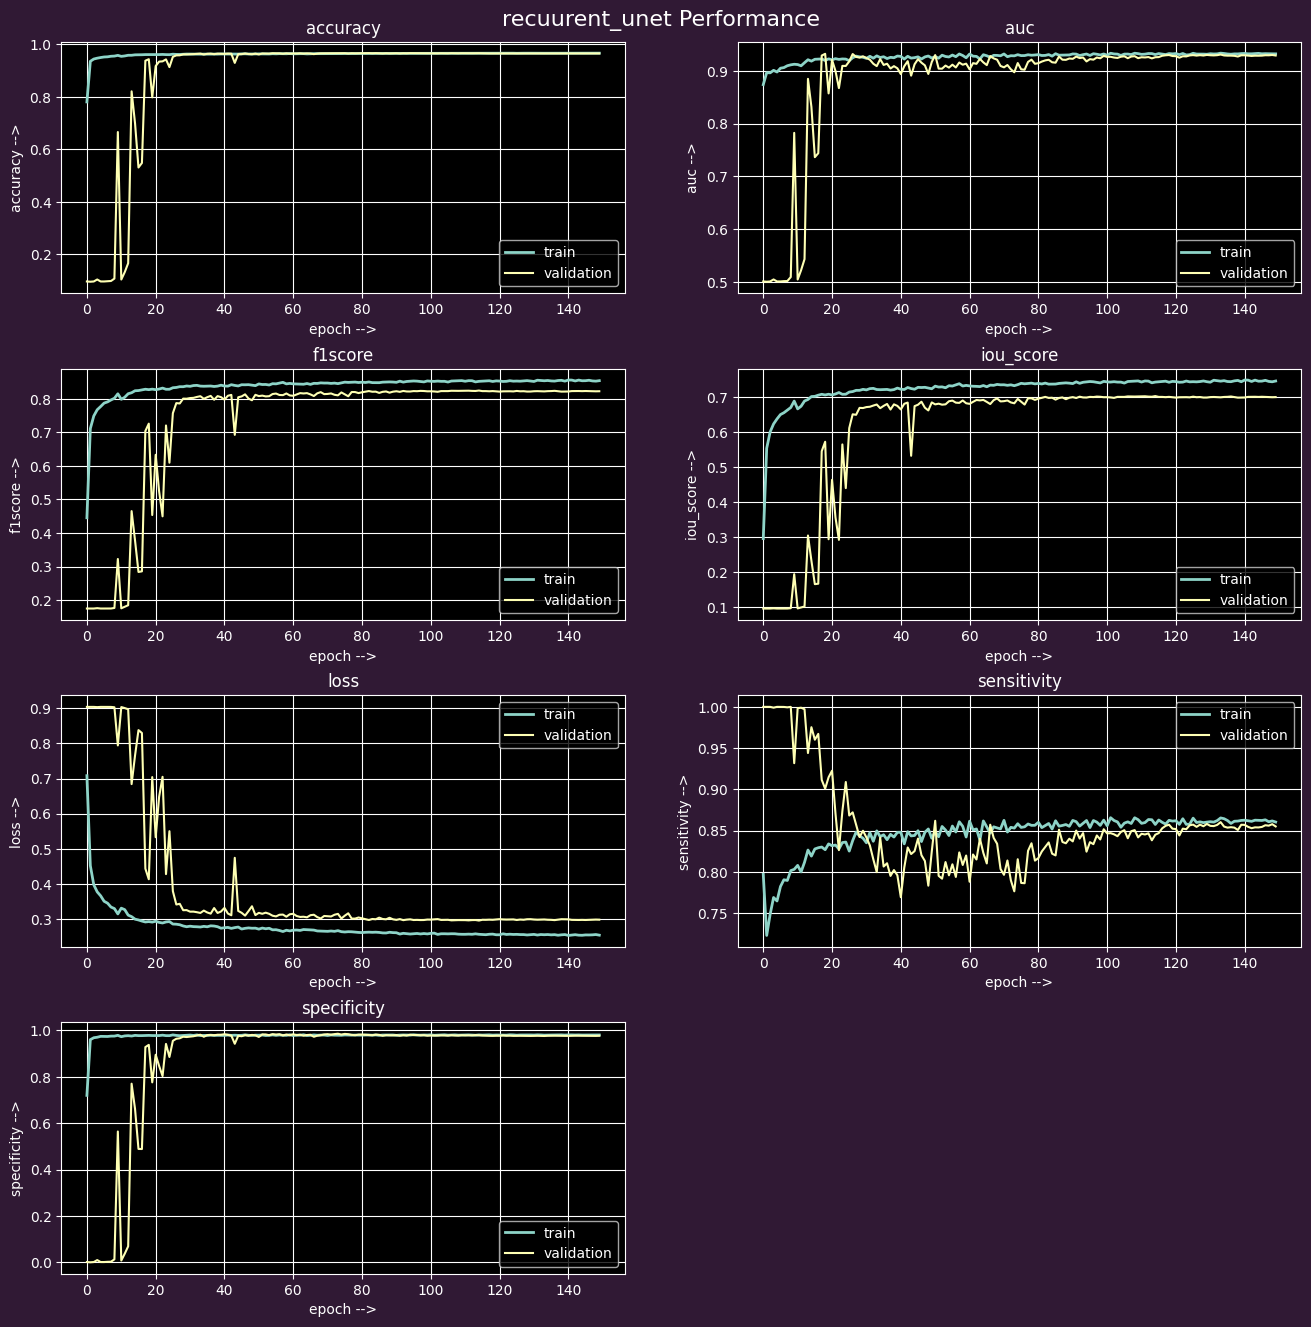

In [61]:
# model_name = "unet"
# History = History_dict[ model_name]

metric_List = list(History.keys())


plt.figure(figsize = (16,16),facecolor='#301934').suptitle(model_name+" Performance",fontsize=16, y=0.90)
for i,metric in enumerate(metric_List[:7],1):
    plt.subplot(4,2,i)
    plt.plot(History[metric],label='train',linewidth=2)
    plt.plot(History['val_'+ metric],label='validation',linewidth=1.5)
    plt.title(metric)
    plt.legend()
    plt.ylabel(metric + ' -->')
    plt.xlabel('epoch -->')
    plt.subplots_adjust(wspace=0.2, hspace=0.3) 
    plt.grid()
plt.show()

### > comparision plot

### > Sample Predictions

In [68]:
def get_pred_mask(image):
    return Model.predict(tf.expand_dims(image,axis=0),verbose=0)[0]

In [63]:
# def get_aug_image(image):
#     mask_pred_1 = get_pred_mask(image)
    
#     mask_pred_2 = get_pred_mask(np.fliplr(image))
#     mask_pred_2 = np.fliplr(mask_pred_2)
    
#     mask_pred_3 = get_pred_mask(np.flipud(image))
#     mask_pred_3 = np.flipud(mask_pred_3)
    
#     # mask_pred_4 = get_pred_mask(np.flipud(np.fliplr(image)))
#     # mask_pred_4 = np.flipud(np.fliplr(mask_pred_4))
    
#     mask_pred_aug = (mask_pred_1 + mask_pred_2 + mask_pred_3 )/3
#     return mask_pred_1 ,mask_pred_aug

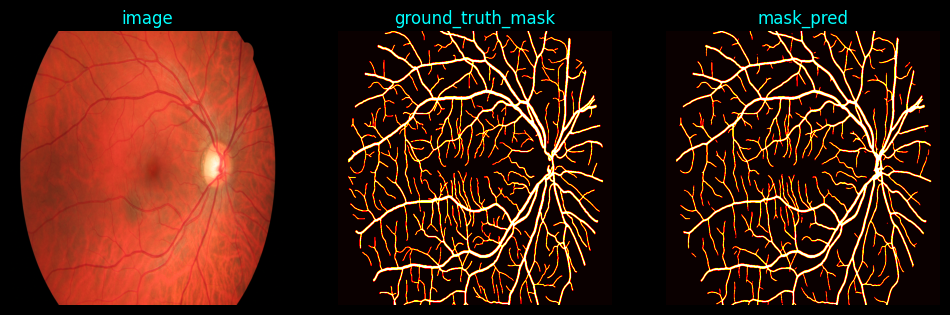

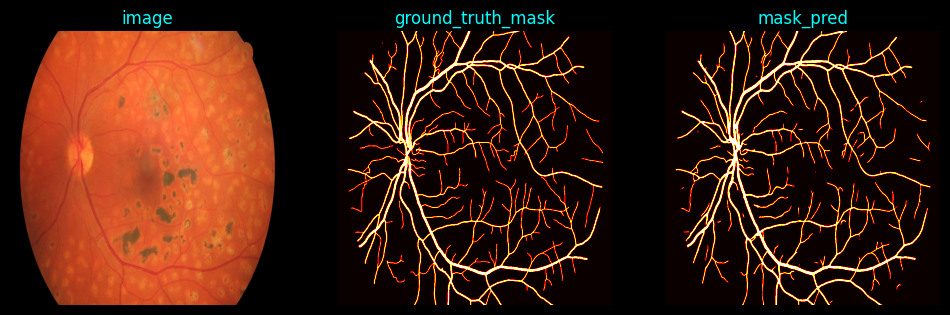

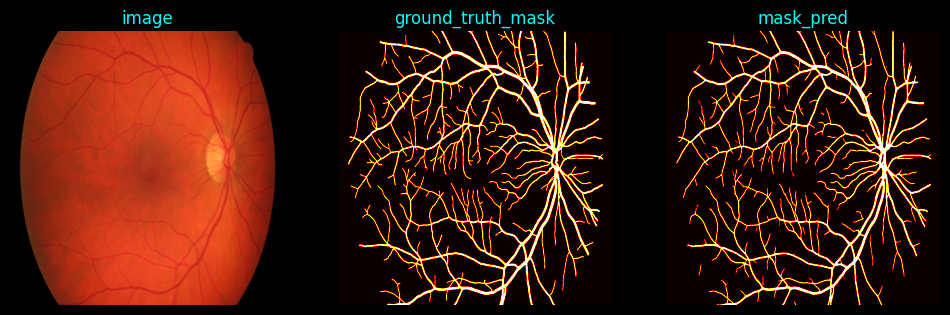

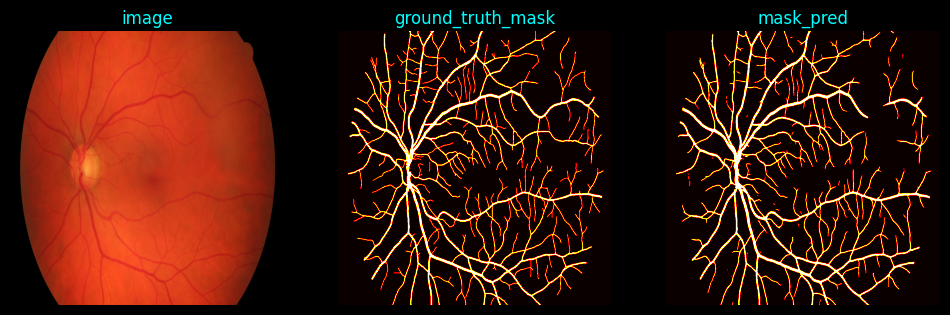

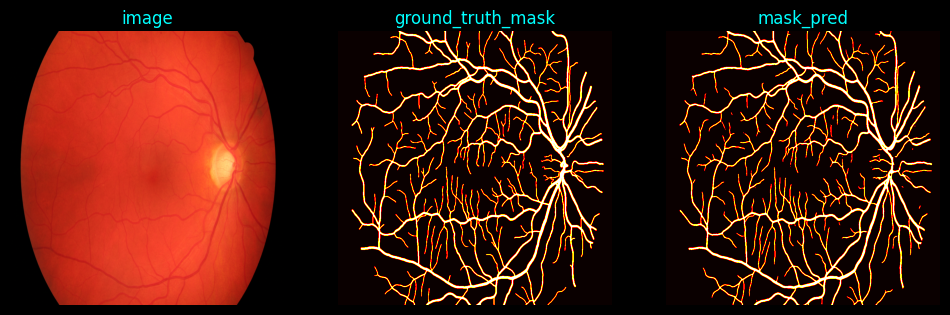

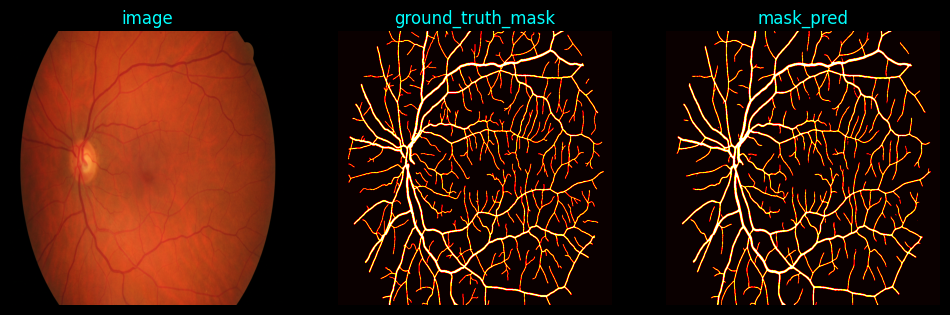

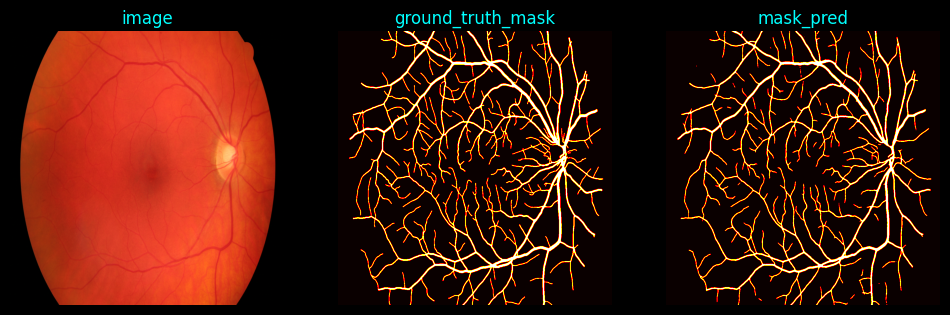

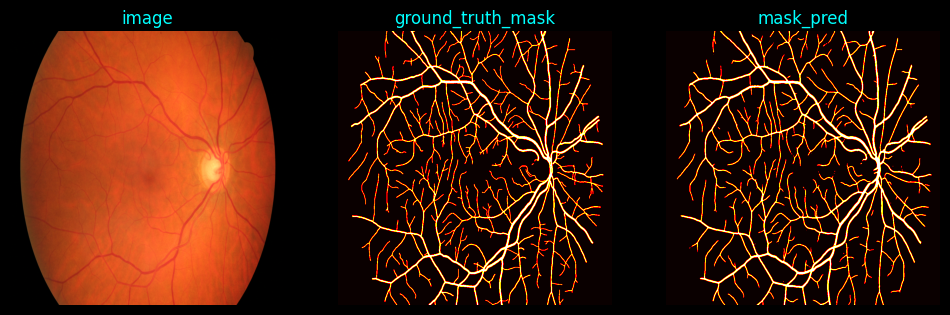

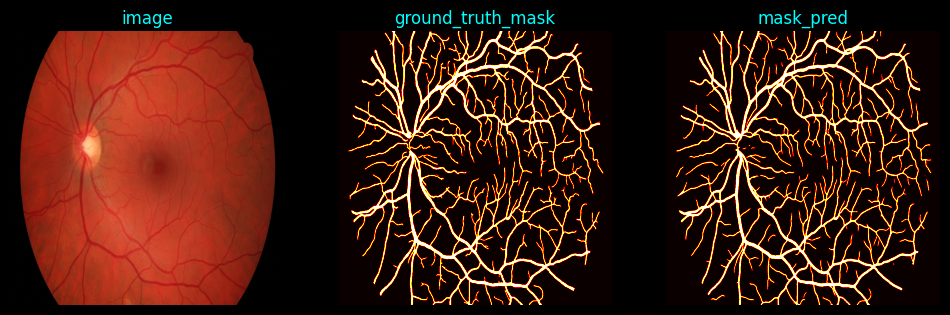

In [71]:
threshold = 0.5
for image , mask in zip(test_images , test_masks):
# for image , mask in zip(test_images , test_masks):
    
#     print(image.min() ,image.max() , mask.min() ,mask.max())
#     mask_pred , mask_pred_aug = get_aug_image(image)
    mask_pred = get_pred_mask(image)
    
    mask_pred = (mask_pred>threshold)
#     mask_pred_aug = (mask_pred_aug > threshold)
        
    image = (image-image.min()) / (image.max()-image.min()) 
    
    display_images([image[...,:3] ,mask,mask_pred],['image','ground_truth_mask','mask_pred','mask_pred_aug'],size = 4,cmap='hot')

In [ ]:
# np.max(new_image)

In [ ]:
new_image = prev_Model(train_images[index:index+1])[0]
display_images([train_images[index][...,:3],new_image ,train_masks[index],],cmap = 'gray',size = 6,scaling='minmax',grid=(1,3))

In [ ]:
def image_gaus_edge(image,thresh1= 50 , kernel_size = 5,channel = None):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if(np.ndim(image)==3):
        if(channel):
            gray =  image[...,channel]
        else :
            gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    # print(np.shape(image))
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size , kernel_size ), 0)  # Kernel size (5, 5), sigma = 0
    # Apply edge detection using Canny
    edge = cv2.Canny(blurred, threshold1=thresh1, threshold2=100)  # Adjust thresholds as needed

    return edge

In [ ]:
min_ = np.min(new_image ,axis = (0,1))
max_ = np.max(new_image ,axis = (0,1)) 

new_image = 255*(new_image - min_) /( max_ - min_)
new_image = np.array( new_image , dtype ='uint8')

In [ ]:
img_edge_1= image_gaus_edge(new_image, 300,3,channel=1)
img_edge_2= image_gaus_edge(new_image, 100,5,channel=0)
display_images([img_edge_1,img_edge_2,new_image,train_masks[index]] ,size=5,cmap = 'gray' , grid=(3,2))

## > Saving Results

In [ ]:
# [ 'pretrained_unet' ,'residual_unet' ,'r2_unet' , 'residual_attention_aunet']

In [63]:
import json

In [ ]:
with open(base_path+'dataset/account_content','r') as file:
    content = file.read()
Folder_key_dict  = json.loads(content)
# Address_dict

In [ ]:
# pip install mediafire

In [ ]:
from mediafire import MediaFireApi
from mediafire import MediaFireUploader
api = MediaFireApi()
uploader = MediaFireUploader(api)

In [64]:
def upload_models():
    base_path = 'Models' 
    try:
        os.mkdir(base_path)
    except:
        pass
        
#     folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
#     print(folder_key)
    
    for model_name , model in Model_dict.items():
        model_save_path = base_path + '/' + model_name + '.keras'
        model.save(model_save_path)

#         session = api.user_get_session_token(
#                         email='prajwalsharma.bt21cse@pec.edu.in',
#                         password='Praju@321',
#                         app_id='42511',
#         )
        
#         api.session = session
    
#         try:
#             print(model_name ,'upload started >>>')
#             with open(model_save_path ,'rb') as model_file:
#                 uploader = MediaFireUploader(api)
#                 %time result = uploader.upload(model_file , model_name , folder_key=folder_key)
#             print(model_name ,'uploaded successfully')
#             print('------------------------------------------------------------------------------------')
#         except Exception as e:
#             print("Error :",e)

In [65]:
def upload_Dict(Dict , dict_name = 'history_dict1'):
    base_path = 'Meta' 
    try:
        os.mkdir(base_path)
    except:
        pass
    
#     folder_key = Folder_key_dict['EyeSegmentation'][dataset_name][base_path]['folder_key']
#     print(folder_key)
    
    dict_file_name = base_path + '/' + dict_name+'.txt'
    
    dict_str = dict_str = json.dumps(Dict)
    dict_str = dict_str.encode()
    with open(dict_file_name,'wb') as dict_file :
        dict_file.write(dict_str)

#     session = api.user_get_session_token(
#                     email='prajwalsharma.bt21cse@pec.edu.in',
#                     password='Praju@321',
#                     app_id='42511',
#     )
#     api.session = session

#     try:
#         with open(dict_file_name ,'rb') as dict_file:
#             dict_str2 = dict_file.read()
#             Dict2 = json.loads(dict_str2)
            
#             uploader = MediaFireUploader(api)
#             %time result = uploader.upload(dict_file , dict_name , folder_key=folder_key) 
    
#     except Exception as e:
#         print("Error :",e)

In [66]:
upload_models()

In [67]:
upload_Dict(History_dict)

In [ ]:
# Model = models.load_model('Models/pretrained_unet_keras',compile=False)
# Model.evaluate(test_images,test_masks)

In [ ]:
# with open('Meta/history_dict_.txt' ,'rb') as dict_file:
#     dict_str2 = dict_file.read()
# Dict2 = json.loads(dict_str2)
# Dict2

In [ ]:
api = MediaFireApi()
# uploader = MediaFireUploader(api)

session = api.user_get_session_token(
                email='prajwalsharma.bt21cse@pec.edu.in',
                password='Praju@321',
                app_id='42511',
)